# imports and utils

In [1]:
import pickle
from srgnn_model import SRGNN_model
from tagnn_model import TAGNN_model
from srgnn_datasets import SRGNN_Map_Dataset, Augment_Matrix_Dataset, SRGNN_sampler, Clusters_Matrix_Dataset
from utils import load_model, get_dataset
import os

from torch.utils.data import DataLoader

import numpy as np
import pandas as pd

from tqdm import tqdm

import yaml
import torch
from pytorch_lightning import Trainer
from math import ceil

from sklearn.manifold import TSNE
import plotly.graph_objects as go

/home/kacper/anaconda3/envs/gpu_torch/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
torch.set_float32_matmul_precision('medium')

In [3]:
def get_metrics_by_hand(model, dataloaders):
    m=[]
    for i, d in enumerate(dataloaders):
        hit,mrr=[],[]
        for batch in tqdm(d, total=ceil(normal_test_dataset.length/opt.batchSize)):
            batch=[x.to('cuda') for x in batch]
            sub_scores, targets=model.predict_step(batch)
            targets=targets.flatten()
            for score, target in zip(sub_scores, targets):
                correct_pred=torch.isin(target - 1, score)
                hit.append(correct_pred.cpu().numpy())
                if not correct_pred:
                    mrr.append(0)
                else:
                    mrr.append(1 / (torch.where(score == target - 1)[0][0] + 1).cpu().numpy())
        m.append((i, np.average(hit),np.average(mrr)))
    return m


# Normal model

In [4]:
run_id='jxgwsuta'
#run_id= 'run-20240614_112333-4o6dnpcx' # digineticax b4 vacation
#run_id='run-20240404_162708-ekuo66ei' # diginetica OLD
#run_id='run-20240614_153017-zgpiq2xg' # yoochoose1/4
model,opt=load_model(run_id)
test_data = pickle.load(open('../datasets/' + opt.dataset + '/test.txt', 'rb'))

{'dataset': 'diginetica', 'batchSize': 100, 'hiddenSize': 100, 'epoch': 30, 'lr': 0.001, 'lr_dc': 0.1, 'lr_dc_step': 2, 'lr_scheduler': 'step', 'lr_milestones': ([2, 5, 8],), 'l2': 1e-05, 'step': 2, 'patience': 5, 'nonhybrid': False, 'validation': True, 'valid_portion': 0.1, 'pretrained_embedings': False, 'unfreeze_epoch': 0, 'gmm': True, 'augment_matrix': False, 'augment_clusters': False, 'augment_old_run_id': None, 'augment_clip': 0, 'augment_normalize': False, 'augment_raw': False, 'weight_init': 'normal', 'augment_categories': False, 'augment_nogmm': 16, 'augment_p': 1.0, 'augment_mean': 0.01, 'augment_std': 0.0, 'augment_gmm_init': 'k-means++', 'augment_prenormalize_distances': False, 'augment_noise_p': 1, 'augment_alg': 'gmm', 'gmm_covariance_type': 'full', 'gmm_tol': 0.001}


In [5]:
normal_test_dataset=SRGNN_Map_Dataset(test_data, shuffle=False)

normal_test_dataloader=DataLoader(normal_test_dataset, 
                            num_workers=os.cpu_count(),  
                            sampler=SRGNN_sampler(normal_test_dataset, opt.batchSize, shuffle=False, drop_last=False)
                            )

data masking start


100%|██████████| 64/64 [00:00<00:00, 236.03it/s]

done masking


In [6]:
trainer=Trainer(limit_test_batches=ceil(normal_test_dataset.length/opt.batchSize),
                limit_predict_batches=ceil(normal_test_dataset.length/opt.batchSize))

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/kacper/anaconda3/envs/gpu_torch/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default


In [7]:
runs=[
    'run-20240805_152836-9qftnkuw',
    'run-20240614_112333-4o6dnpcx', # before vacation
  #  'run-20240614_110415-s1ibwx8z',
  #  'run-20240614_103554-9oalum92',
  #  'run-20240614_100940-1qzerry1',
  #  'run-20240614_090951-1we03ydl',
  #  'run-20240531_122335-i78k1rzu',
]

In [8]:
for run_id in runs:
    model,opt=load_model(run_id)
    print('Metrics on normal Adjacency matrix')
    print(run_id)
    trainer.test(model, normal_test_dataloader)

{'dataset': 'diginetica', 'batchSize': 100, 'hiddenSize': 100, 'epoch': 60, 'lr': 0.001, 'lr_dc': 0.1, 'lr_dc_step': 2, 'l2': 1e-05, 'step': 2, 'patience': 5, 'nonhybrid': False, 'validation': True, 'valid_portion': 0.1, 'pretrained_embedings': False, 'unfreeze_epoch': 1, 'gmm': False, 'augment_matrix': False, 'augment_clusters': False, 'augment_old_run_id': None, 'augment_clip': 0, 'augment_normalize': False, 'augment_raw': False, 'weight_init': 'normal', 'augment_categories': False, 'augment_nogmm': 16, 'augment_p': 1.0, 'augment_mean': 0.01, 'augment_std': 0.0, 'augment_gmm_init': 'k-means++', 'augment_prenormalize_distances': False, 'augment_noise_p': 1}
Metrics on normal Adjacency matrix
run-20240805_152836-9qftnkuw


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 609/609 [00:18<00:00, 32.73it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_hit             50.71292495727539
        test_loss            5.497653484344482
        test_mrr             17.75798225402832
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
{'dataset': 'diginetica', 'batchSize': 100, 'hiddenSize': 100, 'epoch': 60, 'lr': 0.001, 'lr_dc': 0.1, 'lr_dc_step': 2, 'l2': 1e-05, 'step': 2, 'patience': 4, 'nonhybrid': False, 'validation': True, 'valid_portion': 0.1, 'pretrained_embedings': False, 'unfreeze_epoch': 1, 'gmm': False, 'augment_matrix': False, 'augment_clusters': False, 'augment_old_run_id': None, 'augment_clip

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Metrics on normal Adjacency matrix
run-20240614_112333-4o6dnpcx
Testing DataLoader 0: 100%|██████████| 609/609 [00:17<00:00, 34.05it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_hit             50.71383285522461
        test_loss            5.507214069366455
        test_mrr             17.64642906188965
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


# tagnn

In [8]:
normal_test_dataloader=DataLoader(normal_test_dataset, 
                            num_workers=os.cpu_count(),  
                            sampler=SRGNN_sampler(normal_test_dataset, 32, shuffle=False, drop_last=False)
                            )
trainer=Trainer(limit_test_batches=ceil(normal_test_dataset.length/32),
                limit_predict_batches=ceil(normal_test_dataset.length/32))

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [9]:
#for run_id in runs:
run_id='run-20240627_124634-3sqmsb5q'
model,opt=load_model_tagnn(run_id)
print('Metrics on normal Adjacency matrix')
print(run_id)
trainer.test(model, normal_test_dataloader)

Metrics on normal Adjacency matrix
run-20240627_124634-3sqmsb5q


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 1902/1902 [01:00<00:00, 31.29it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_hit            49.910011291503906
        test_loss            5.666360378265381
        test_mrr            17.279094696044922
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 5.666360378265381,
  'test_hit': 49.910011291503906,
  'test_mrr': 17.279094696044922}]

In [15]:
runs=[
    'run-20240627_183323-4ak5m39f',
    'run-20240627_155659-9kgnghb3',
]

for run_id in runs:
    model,opt=load_model_tagnn(run_id)
    dataset=get_dataset(opt)
    am_test_dataloader=DataLoader(dataset,    num_workers=os.cpu_count(),  
                            sampler=SRGNN_sampler(dataset, 32, shuffle=False, drop_last=False)
                         )
    print(run_id)
    print('Distnace Augmentation:', opt.augment_matrix,
        'Clusters:', opt.augment_clusters,
          'Categories:', opt.augment_categories,
          'Noise std: ', opt.augment_std
          )
    trainer.test(model, {'augmented':am_test_dataloader, 'normal':normal_test_dataloader})

data masking start


100%|██████████| 64/64 [00:00<00:00, 189.33it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


done masking
run-20240627_183323-4ak5m39f
Distnace Augmentation: True Clusters: True Categories: False Noise std:  0.01
Testing DataLoader 1: 100%|██████████| 1902/1902 [01:01<00:00, 31.09it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0             DataLoader 1
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_hit             48.87112808227539        48.89084243774414
        test_loss            5.810800552368164        5.809542179107666
        test_mrr            17.120683670043945       17.114744186401367
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
data masking start


100%|██████████| 64/64 [00:00<00:00, 346.86it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


done masking
run-20240627_155659-9kgnghb3
Distnace Augmentation: True Clusters: True Categories: False Noise std:  0.01
Testing DataLoader 1: 100%|██████████| 1902/1902 [01:01<00:00, 30.83it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0             DataLoader 1
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_hit             50.33921813964844       50.393436431884766
        test_loss            5.575467109680176        5.574565410614014
        test_mrr            17.668127059936523        17.66415786743164
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


# test multiple models, trained with different augmentations

In [8]:
# yoochoose  
runs=[
    'run-20240619_102057-3gibtayg'
]

In [13]:
runs=[
    'run-20240621_131456-not829vl',
    'run-20240614_142621-t3g6tq0x',
    'run-20240614_131608-ej263e5q',
    'run-20240614_121256-eb9o86a0',
    'run-20240614_115350-nowjww5i',
    'run-20240614_125159-mqzvnmnm', # multistep
    'run-20240607_124758-qm1wk8n1'
    ]


In [43]:
runs=[
    '9kf534bm', 
    'nbhakjb7', # updated blur - +=(U<p)*N

    'fmm07us9', # old blur - if u<p: +=N
    'wtqp9kti',

    'fbshwixh', # old, a bit bugged
 ]

In [44]:
for run_id in runs:
    model,opt=load_model(run_id)
    dataset=get_dataset(opt)
    am_test_dataloader=DataLoader(dataset,    num_workers=os.cpu_count(),  
                            sampler=SRGNN_sampler(dataset, opt.batchSize, shuffle=False, drop_last=False)
                         )
    print(run_id)
    print('Distnace Augmentation:', opt.augment_matrix,
        'Clusters:', opt.augment_clusters,
          'Categories:', opt.augment_categories,
          'Noise std: ', opt.augment_std,
          'base model', opt.augment_old_run_id,
          )
    trainer.test(model, {'augmented':am_test_dataloader, 'normal':normal_test_dataloader})

{'dataset': 'diginetica', 'batchSize': 100, 'hiddenSize': 100, 'epoch': 30, 'lr': 0.001, 'lr_dc': 0.1, 'lr_dc_step': 2, 'l2': 1e-06, 'step': 2, 'patience': 4, 'nonhybrid': False, 'validation': True, 'valid_portion': 0.1, 'pretrained_embedings': False, 'unfreeze_epoch': 0, 'gmm': [], 'augment_matrix': True, 'augment_clusters': True, 'augment_old_run_id': 'run-20240614_112333-4o6dnpcx', 'augment_clip': 0, 'augment_normalize': True, 'augment_raw': False, 'weight_init': 'normal', 'augment_categories': False, 'augment_nogmm': 128, 'augment_p': 0.5, 'augment_mean': 0.01, 'augment_std': 0.01, 'augment_gmm_init': 'k-means++', 'augment_prenormalize_distances': False, 'augment_noise_p': 0.5}
data masking start


100%|██████████| 64/64 [00:00<00:00, 410.98it/s]
/home/kacper/GNN_Master/srgnn/srgnn_datasets.py:456: RuntimeWarning: divide by zero encountered in divide
  self.cluster_distances = 1 / self.cluster_distances
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


done masking
9kf534bm
Distnace Augmentation: True Clusters: True Categories: False Noise std:  0.01 base model run-20240614_112333-4o6dnpcx
Testing DataLoader 1: 100%|██████████| 609/609 [00:17<00:00, 35.06it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0             DataLoader 1
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_hit            51.045074462890625        51.05447006225586
        test_loss            5.485401153564453        5.490163326263428
        test_mrr            18.079872131347656       18.067853927612305
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
{'dataset': 'diginetica', 'batchSize': 100, 'hiddenSize': 100, 'epoch': 30, 'lr': 0.001, 'lr_dc': 0.1, 'lr_dc_step': 2, 'l2': 1e-06, 'step':

100%|██████████| 64/64 [00:00<00:00, 419.45it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


done masking
nbhakjb7
Distnace Augmentation: True Clusters: True Categories: False Noise std:  0.01 base model run-20240614_112333-4o6dnpcx
Testing DataLoader 1: 100%|██████████| 609/609 [00:16<00:00, 36.15it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0             DataLoader 1
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_hit             51.1870231628418         51.16567611694336
        test_loss            5.495455741882324        5.49939489364624
        test_mrr             17.97854232788086        17.9717960357666
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
{'dataset': 'diginetica', 'batchSize': 100, 'hiddenSize': 100, 'epoch': 30, 'lr': 0.001, 'lr_dc': 0.1, 'lr_dc_step': 2, 'l2': 1e-06, 'step': 2

100%|██████████| 64/64 [00:00<00:00, 199.02it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


done masking
fmm07us9
Distnace Augmentation: True Clusters: True Categories: False Noise std:  0.01 base model run-20240614_112333-4o6dnpcx
Testing DataLoader 1: 100%|██████████| 609/609 [00:17<00:00, 35.42it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0             DataLoader 1
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_hit             51.12910079956055       51.176719665527344
        test_loss            5.484712600708008       5.4867682456970215
        test_mrr            17.989627838134766       17.982770919799805
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
{'dataset': 'diginetica', 'batchSize': 100, 'hiddenSize': 100, 'epoch': 30, 'lr': 0.001, 'lr_dc': 0.1, 'lr_dc_step': 2, 'l2': 1e-06, 'step':

100%|██████████| 64/64 [00:00<00:00, 426.96it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


done masking
wtqp9kti
Distnace Augmentation: True Clusters: True Categories: False Noise std:  0.01 base model run-20240614_112333-4o6dnpcx
Testing DataLoader 1: 100%|██████████| 609/609 [00:17<00:00, 35.39it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0             DataLoader 1
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_hit            50.867279052734375        50.89802551269531
        test_loss            5.483616352081299        5.484720230102539
        test_mrr            17.908790588378906        17.91218376159668
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
{'dataset': 'diginetica', 'batchSize': 100, 'hiddenSize': 100, 'epoch': 30, 'lr': 0.001, 'lr_dc': 0.1, 'lr_dc_step': 2, 'l2': 1e-06, 'step':

100%|██████████| 64/64 [00:00<00:00, 426.28it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


done masking
fbshwixh
Distnace Augmentation: True Clusters: True Categories: False Noise std:  0.01 base model run-20240614_112333-4o6dnpcx
Testing DataLoader 1: 100%|██████████| 609/609 [00:17<00:00, 35.41it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0             DataLoader 1
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_hit             50.99654769897461        50.96744155883789
        test_loss            5.49594259262085         5.498101234436035
        test_mrr            18.009990692138672       18.015676498413086
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


In [45]:
results={}
for run_id in runs:
    model,opt=load_model(run_id)
    #dataset=get_dataset(opt)
   # am_test_dataloader=DataLoader(dataset,    num_workers=os.cpu_count(),  
     #                       sampler=SRGNN_sampler(dataset, opt.batchSize, shuffle=False, drop_last=False)
      #                   )
    print(run_id)
    print('Distnace Augmentation:', opt.augment_matrix,
        'Clusters:', opt.augment_clusters,
          'Categories:', opt.augment_categories,
          'Noise std: ', opt.augment_std,
          'base model', opt.augment_old_run_id,
          )
    results[run_id]=get_metrics_by_hand(model, [normal_test_dataloader])

{'dataset': 'diginetica', 'batchSize': 100, 'hiddenSize': 100, 'epoch': 30, 'lr': 0.001, 'lr_dc': 0.1, 'lr_dc_step': 2, 'l2': 1e-06, 'step': 2, 'patience': 4, 'nonhybrid': False, 'validation': True, 'valid_portion': 0.1, 'pretrained_embedings': False, 'unfreeze_epoch': 0, 'gmm': [], 'augment_matrix': True, 'augment_clusters': True, 'augment_old_run_id': 'run-20240614_112333-4o6dnpcx', 'augment_clip': 0, 'augment_normalize': True, 'augment_raw': False, 'weight_init': 'normal', 'augment_categories': False, 'augment_nogmm': 128, 'augment_p': 0.5, 'augment_mean': 0.01, 'augment_std': 0.01, 'augment_gmm_init': 'k-means++', 'augment_prenormalize_distances': False, 'augment_noise_p': 0.5}
9kf534bm
Distnace Augmentation: True Clusters: True Categories: False Noise std:  0.01 base model run-20240614_112333-4o6dnpcx


100%|██████████| 609/609 [00:18<00:00, 32.81it/s]


{'dataset': 'diginetica', 'batchSize': 100, 'hiddenSize': 100, 'epoch': 30, 'lr': 0.001, 'lr_dc': 0.1, 'lr_dc_step': 2, 'l2': 1e-06, 'step': 2, 'patience': 4, 'nonhybrid': False, 'validation': True, 'valid_portion': 0.1, 'pretrained_embedings': False, 'unfreeze_epoch': 0, 'gmm': [], 'augment_matrix': True, 'augment_clusters': True, 'augment_old_run_id': 'run-20240614_112333-4o6dnpcx', 'augment_clip': 0, 'augment_normalize': True, 'augment_raw': False, 'weight_init': 'normal', 'augment_categories': False, 'augment_nogmm': 128, 'augment_p': 0.5, 'augment_mean': 0.01, 'augment_std': 0.01, 'augment_gmm_init': 'k-means++', 'augment_prenormalize_distances': False, 'augment_noise_p': 0.5}
nbhakjb7
Distnace Augmentation: True Clusters: True Categories: False Noise std:  0.01 base model run-20240614_112333-4o6dnpcx


100%|██████████| 609/609 [00:18<00:00, 33.04it/s]


{'dataset': 'diginetica', 'batchSize': 100, 'hiddenSize': 100, 'epoch': 30, 'lr': 0.001, 'lr_dc': 0.1, 'lr_dc_step': 2, 'l2': 1e-06, 'step': 2, 'patience': 4, 'nonhybrid': False, 'validation': True, 'valid_portion': 0.1, 'pretrained_embedings': False, 'unfreeze_epoch': 0, 'gmm': [], 'augment_matrix': True, 'augment_clusters': True, 'augment_old_run_id': 'run-20240614_112333-4o6dnpcx', 'augment_clip': 0, 'augment_normalize': True, 'augment_raw': False, 'weight_init': 'normal', 'augment_categories': False, 'augment_nogmm': 128, 'augment_p': 0.5, 'augment_mean': 0.01, 'augment_std': 0.01, 'augment_gmm_init': 'k-means++', 'augment_prenormalize_distances': False, 'augment_noise_p': 0.5}
fmm07us9
Distnace Augmentation: True Clusters: True Categories: False Noise std:  0.01 base model run-20240614_112333-4o6dnpcx


100%|██████████| 609/609 [00:18<00:00, 32.75it/s]


{'dataset': 'diginetica', 'batchSize': 100, 'hiddenSize': 100, 'epoch': 30, 'lr': 0.001, 'lr_dc': 0.1, 'lr_dc_step': 2, 'l2': 1e-06, 'step': 2, 'patience': 4, 'nonhybrid': False, 'validation': True, 'valid_portion': 0.1, 'pretrained_embedings': False, 'unfreeze_epoch': 0, 'gmm': [], 'augment_matrix': True, 'augment_clusters': True, 'augment_old_run_id': 'run-20240614_112333-4o6dnpcx', 'augment_clip': 0, 'augment_normalize': True, 'augment_raw': False, 'weight_init': 'normal', 'augment_categories': False, 'augment_nogmm': 128, 'augment_p': 0.5, 'augment_mean': 0.01, 'augment_std': 0.01, 'augment_gmm_init': 'k-means++', 'augment_prenormalize_distances': False, 'augment_noise_p': 0.5}
wtqp9kti
Distnace Augmentation: True Clusters: True Categories: False Noise std:  0.01 base model run-20240614_112333-4o6dnpcx


100%|██████████| 609/609 [00:18<00:00, 32.90it/s]


{'dataset': 'diginetica', 'batchSize': 100, 'hiddenSize': 100, 'epoch': 30, 'lr': 0.001, 'lr_dc': 0.1, 'lr_dc_step': 2, 'l2': 1e-06, 'step': 2, 'patience': 4, 'nonhybrid': False, 'validation': True, 'valid_portion': 0.1, 'pretrained_embedings': False, 'unfreeze_epoch': 0, 'gmm': [], 'augment_matrix': True, 'augment_clusters': True, 'augment_old_run_id': 'run-20240614_112333-4o6dnpcx', 'augment_clip': 0, 'augment_normalize': True, 'augment_raw': False, 'weight_init': 'normal', 'augment_categories': False, 'augment_nogmm': 128, 'augment_p': 0.5, 'augment_mean': 0.01, 'augment_std': 0.01, 'augment_gmm_init': 'k-means++', 'augment_prenormalize_distances': False, 'augment_noise_p': 0.5}
fbshwixh
Distnace Augmentation: True Clusters: True Categories: False Noise std:  0.01 base model run-20240614_112333-4o6dnpcx


100%|██████████| 609/609 [00:18<00:00, 33.51it/s]


In [46]:
res_df=pd.DataFrame(results).T.reset_index()
res_df[['DataLoader_id','hit','mrr']]=pd.DataFrame(res_df[0].to_list(), columns=['DataLoader_id','hit','mrr'])
res_df

,index,0,DataLoader_id,hit,mrr
0,9kf534bm,"(0, 0.5105162838082092, 0.1806362893113383)",0,0.510516,0.180636
1,nbhakjb7,"(0, 0.5116172072693812, 0.1796853487105808)",0,0.511617,0.179685
2,fmm07us9,"(0, 0.5117157974300831, 0.179782890865602)",0,0.511716,0.179783
3,wtqp9kti,"(0, 0.5089388412369779, 0.17909009524408923)",0,0.508939,0.179090
4,fbshwixh,"(0, 0.509645404055342, 0.18010894678173336)",0,0.509645,0.180109


In [47]:
res_df[['hit','mrr']].iloc[:2].mean(), res_df[['hit','mrr']].iloc[2:4].mean(), res_df[['hit','mrr']].iloc[4]

(hit    0.511067
 mrr    0.180161
 dtype: float64,
 hit    0.510327
 mrr    0.179436
 dtype: float64,
 hit    0.509645
 mrr    0.180109
 Name: 4, dtype: float64)

# Best models - from wandb

## yoochoose

In [9]:
runs=[
    'run-20240523_184137-2hmeyq20',
]

In [10]:
normal_test_dataset=SRGNN_Map_Dataset(test_data, shuffle=False)

normal_test_dataloader=DataLoader(normal_test_dataset, 
                            num_workers=os.cpu_count(),  
                            sampler=SRGNN_sampler(normal_test_dataset, opt.batchSize, shuffle=False, drop_last=False)
                            )

data masking start


100%|██████████| 64/64 [00:00<00:00, 265.47it/s]

done masking


In [11]:
for run_id in runs:
    model,opt=load_model(run_id)
    dataset=get_dataset(opt)
    am_test_dataloader=DataLoader(dataset,    num_workers=os.cpu_count(),  
                            sampler=SRGNN_sampler(dataset, opt.batchSize, shuffle=False, drop_last=False)
                         )
    print(run_id)
    print('Clusters:', opt.augment_clusters,
        'Normalization:', opt.augment_normalize,
          'Distance clip:', opt.augment_clip,
          'Raw distance:', opt.augment_raw,
          'GNN steps', opt.step,
          'l2 weight decay', opt.l2)
    trainer.test(model, {'augmented':am_test_dataloader, 'normal':normal_test_dataloader})

data masking start


100%|██████████| 64/64 [00:00<00:00, 182.70it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


done masking
run-20240523_184137-2hmeyq20
Clusters: True Normalization: True Distance clip: 0 Raw distance: False GNN steps 3 l2 weight decay 0.0001
Testing DataLoader 1: 100%|██████████| 559/559 [00:17<00:00, 31.42it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0             DataLoader 1
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_hit             71.0865249633789         71.07400512695312
        test_loss            4.242622375488281        4.240519046783447
        test_mrr             31.52954864501953       31.517486572265625
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


## digenetica

In [7]:
runs=[
    'fbshwixh',
    'qjryadwd',
    'run-20240503_221548-snlgztbm',
    'run-20240503_180753-7exj1dpy',
]

In [8]:
normal_test_dataset=SRGNN_Map_Dataset(test_data, shuffle=False)

normal_test_dataloader=DataLoader(normal_test_dataset, 
                            num_workers=os.cpu_count(),  
                            sampler=SRGNN_sampler(normal_test_dataset, opt.batchSize, shuffle=False, drop_last=False)
                            )

data masking start


100%|██████████| 64/64 [00:00<00:00, 424.88it/s]

done masking


In [9]:
for run_id in runs:
    model,opt=load_model(run_id)
    dataset=get_dataset(opt)
    am_test_dataloader=DataLoader(dataset,    num_workers=os.cpu_count(),  
                            sampler=SRGNN_sampler(dataset, opt.batchSize, shuffle=False, drop_last=False)
                         )
    print(run_id)
    print('Clusters:', opt.augment_clusters,
        'Normalization:', opt.augment_normalize,
          'Distance clip:', opt.augment_clip,
          'Raw distance:', opt.augment_raw,
          'GNN steps', opt.step,
          'l2 weight decay', opt.l2)
    trainer.test(model, {'augmented':am_test_dataloader, 'normal':normal_test_dataloader})

{'dataset': 'diginetica', 'batchSize': 100, 'hiddenSize': 100, 'epoch': 30, 'lr': 0.001, 'lr_dc': 0.1, 'lr_dc_step': 2, 'l2': 1e-06, 'step': 2, 'patience': 4, 'nonhybrid': False, 'validation': True, 'valid_portion': 0.1, 'pretrained_embedings': False, 'unfreeze_epoch': 0, 'gmm': [], 'augment_matrix': True, 'augment_clusters': True, 'augment_old_run_id': 'run-20240614_112333-4o6dnpcx', 'augment_clip': 0, 'augment_normalize': True, 'augment_raw': False, 'weight_init': 'normal', 'augment_categories': False, 'augment_nogmm': 128, 'augment_p': 0.5, 'augment_mean': 0.01, 'augment_std': 0.01, 'augment_gmm_init': 'k-means++', 'augment_prenormalize_distances': False, 'augment_noise_p': 0.5, 'augment_alg': 'gmm'}
data masking start


100%|██████████| 64/64 [00:00<00:00, 412.54it/s]
/home/kacper/GNN_Master/srgnn/srgnn_datasets.py:453: RuntimeWarning: divide by zero encountered in divide
  self.cluster_distances = 1 / self.cluster_distances


done masking
fbshwixh
Clusters: True Normalization: True Distance clip: 0 Raw distance: False GNN steps 2 l2 weight decay 1e-06


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 1: 100%|██████████| 609/609 [00:17<00:00, 35.26it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0             DataLoader 1
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_hit             50.95430374145508        50.96744155883789
        test_loss            5.495250225067139        5.498101234436035
        test_mrr            18.029483795166016       18.015676498413086
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
{'dataset': 'diginetica', 'batchSize': 100, 'hiddenSize': 100, 'epoch': 30, 'lr': 0.001, 'lr_dc': 0.1, 'lr_dc_step': 2, 'l2': 1e-06, 'step': 2, 'patience': 4, 'nonhybrid': False, 'validation': True, 'valid_portion': 0.1, 'pretrained_embedings': False, 'unfreeze_epoch': 0, 'gmm': 

100%|██████████| 64/64 [00:00<00:00, 214.51it/s]
/home/kacper/GNN_Master/srgnn/srgnn_datasets.py:453: RuntimeWarning: divide by zero encountered in divide
  self.cluster_distances = 1 / self.cluster_distances
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


done masking
qjryadwd
Clusters: True Normalization: True Distance clip: 0 Raw distance: False GNN steps 2 l2 weight decay 1e-06
Testing DataLoader 1: 100%|██████████| 609/609 [00:17<00:00, 35.44it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0             DataLoader 1
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_hit             51.0664176940918        51.112396240234375
        test_loss            5.477573394775391        5.486842155456543
        test_mrr             18.06410789489746        18.04543113708496
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
{'dataset': 'diginetica', 'batchSize': 100, 'hiddenSize': 100, 'epoch': 60, 'lr': 0.001, 'lr_dc': 0.1, 'lr_dc_step': 2, 'l2': 0.0001, 'step': 3, 'patien

FileNotFoundError: [Errno 2] No such file or directory: '../datasets/diginetica/item_labels_16_k-means++_100_ekuo66ei.txt'

# Compare best augmented and normal

## load data

In [7]:
import pandas as pd

In [8]:
base_run_id='jxgwsuta' # diginetica
#base_run_id='run-20240422_103727-ex2zwqx6' # yoochoose1/4
base_model,opt=load_model(base_run_id)

aug_run_id='8llxhkxm'
aug_model,aug_opt=load_model(aug_run_id) # diginetica
#aug_model,aug_opt=load_model('run-20240523_184137-2hmeyq20') # yoochoose1/4

test_data = pickle.load(open('../datasets/' + opt.dataset + '/test.txt', 'rb'))

{'dataset': 'diginetica', 'batchSize': 100, 'hiddenSize': 100, 'epoch': 30, 'lr': 0.001, 'lr_dc': 0.1, 'lr_dc_step': 2, 'lr_scheduler': 'step', 'lr_milestones': ([2, 5, 8],), 'l2': 1e-05, 'step': 2, 'patience': 5, 'nonhybrid': False, 'validation': True, 'valid_portion': 0.1, 'pretrained_embedings': False, 'unfreeze_epoch': 0, 'gmm': True, 'augment_matrix': False, 'augment_clusters': False, 'augment_old_run_id': None, 'augment_clip': 0, 'augment_normalize': False, 'augment_raw': False, 'weight_init': 'normal', 'augment_categories': False, 'augment_nogmm': 16, 'augment_p': 1.0, 'augment_mean': 0.01, 'augment_std': 0.0, 'augment_gmm_init': 'k-means++', 'augment_prenormalize_distances': False, 'augment_noise_p': 1, 'augment_alg': 'gmm', 'gmm_covariance_type': 'full', 'gmm_tol': 0.001}
{'dataset': 'diginetica', 'batchSize': 100, 'hiddenSize': 100, 'epoch': 30, 'lr': 0.001, 'lr_dc': 0.1, 'lr_dc_step': 2, 'lr_scheduler': 'step', 'lr_milestones': ([2, 5, 8],), 'l2': 1e-06, 'step': 2, 'patience

In [9]:
test_sessions, test_targets, test_sids=test_data[:3]
test_session_ids=set(map(int, test_sids))

In [10]:
aug_opt.augment_noise_p=0
aug_opt.augment_p=1
aug_dataset=get_dataset(aug_opt, test_data, shuffle=False)

{'dataset': 'diginetica', 'batchSize': 100, 'hiddenSize': 100, 'epoch': 30, 'lr': 0.001, 'lr_dc': 0.1, 'lr_dc_step': 2, 'lr_scheduler': 'step', 'lr_milestones': ([2, 5, 8],), 'l2': 1e-05, 'step': 2, 'patience': 5, 'nonhybrid': False, 'validation': True, 'valid_portion': 0.1, 'pretrained_embedings': False, 'unfreeze_epoch': 0, 'gmm': True, 'augment_matrix': False, 'augment_clusters': False, 'augment_old_run_id': None, 'augment_clip': 0, 'augment_normalize': False, 'augment_raw': False, 'weight_init': 'normal', 'augment_categories': False, 'augment_nogmm': 16, 'augment_p': 1.0, 'augment_mean': 0.01, 'augment_std': 0.0, 'augment_gmm_init': 'k-means++', 'augment_prenormalize_distances': False, 'augment_noise_p': 1, 'augment_alg': 'gmm', 'gmm_covariance_type': 'full', 'gmm_tol': 0.001}
data masking start


100%|██████████| 64/64 [00:00<00:00, 412.84it/s]

done masking


In [11]:
test_dataset=SRGNN_Map_Dataset(test_data, shuffle=False)

test_dataloader=DataLoader(test_dataset, 
                            num_workers=os.cpu_count(),  
                            sampler=SRGNN_sampler(test_dataset, opt.batchSize, shuffle=False, drop_last=False)
                            )

data masking start


100%|██████████| 64/64 [00:00<00:00, 349.87it/s]

done masking


In [12]:
stats=[]

base_model.to('cuda')
aug_model.to('cuda')
for batch in tqdm(test_dataloader, total=test_dataset.length//opt.batchSize):
    batch=[b.to('cuda') for b in batch]

    base_sub_scores, targets=base_model.predict_step(batch)
    aug_sub_scores, _=aug_model.predict_step(batch)
    targets=targets.flatten()
    for bscore, augscore, target in zip(base_sub_scores, aug_sub_scores, targets):
        base_correct_pred=torch.isin(target - 1, bscore).cpu()
        base_hit=(base_correct_pred)
        if not base_correct_pred:
            base_mrr=0
        else:
            base_mrr=(1 / (torch.where(bscore == target - 1)[0][0] + 1).cpu())

        aug_correct_pred=torch.isin(target - 1, augscore).cpu()
        aug_hit=(aug_correct_pred)
        if not aug_correct_pred:
            aug_mrr=0
        else:
            aug_mrr=(1 / (torch.where(augscore == target - 1)[0][0] + 1).cpu())
        stats.append((base_mrr, base_hit, aug_mrr, aug_hit))

base_model.to('cpu')
aug_model.to('cpu')
stats=np.array(stats)
print('Base mrr:', 100*np.average(stats[:,0]),'Augmented mrr:', 100*np.average(stats[:,2]),
      '\nBase hit:', 100*np.average(stats[:,1]),'Augmented hit:', 100*np.average(stats[:,3]),)

609it [00:38, 16.01it/s]                         


Base mrr: 17.738202593148433 Augmented mrr: 18.086323706183 
Base hit: 50.91853166387328 Augmented hit: 51.247165532879826


In [13]:
stats_df=pd.DataFrame(stats, columns=['base_mrr', 'base_hit', 'aug_mrr','aug_hit'])
stats_df['session_id']=test_sids
stats_df['target_number']=test_targets
stats_df['session_len']=list(map(lambda x: len(x), test_sessions))

In [14]:
items_df=pd.read_csv(f'../datasets/{opt.dataset}/items.csv').drop(columns=[ 'Unnamed: 0'])
if aug_opt.augment_alg!='raw':
    with open(f"../datasets/diginetica/item_labels_{aug_opt.augment_alg}_{aug_opt.augment_nogmm}_{aug_opt.augment_gmm_init}_{aug_opt.gmm_covariance_type}_{aug_opt.gmm_tol}_{aug_opt.hiddenSize}_{base_run_id.split('-')[-1]}.txt", 'rb') as file:
        item_labels=pickle.load(file)
    items_df['item_cluster']=items_df.item_number.map(lambda x: item_labels[x])
else:
    items_df['item_cluster']=0


In [15]:
if aug_opt.augment_alg!='raw':
    stats_df['clusters']=[ (set(items_df.loc[items_df.item_number.isin(ses)].item_cluster )) for ses in test_sessions]
    stats_df['target_cluster']=stats_df.target_number.map(lambda x: item_labels[x])
    stats_df['target_cluster_in_ses']=stats_df.apply(lambda r: r.target_cluster in r.clusters, axis=1)
    stats_df['no_clusters']=stats_df.clusters.map(lambda x: len(x))
stats_df['repetitions_in_session']=[len(ses)!=len(set(ses)) for ses in test_sessions]

In [16]:
stats_df['target_category']=stats_df.target_number.map(lambda x: items_df.loc[items_df.item_number==x].category.item())
stats_df['categories']=[ (set(items_df.loc[items_df.item_number.isin(ses)].category )) for ses in test_sessions]

stats_df['target_category_in_ses']=stats_df.apply(lambda r: r.target_category in r.categories, axis=1)
stats_df['no_categories']=stats_df.categories.map(lambda x: len(x))

In [17]:
sess_df=pd.read_csv(f'../datasets/{opt.dataset}/test_sessions.csv').drop(columns=[ 'Unnamed: 0'])
sess_df=sess_df.loc[sess_df.session_id.isin(test_session_ids)].reset_index(drop=True)

In [18]:
clicks_df=pd.read_csv(f'../datasets/{opt.dataset}/clicks_df.csv').drop(columns='Unnamed: 0')
clicks_df=clicks_df.loc[clicks_df.session_id.isin(test_session_ids)].reset_index(drop=True)

In [21]:
aug_df=stats_df.loc[
    (stats_df.base_mrr<stats_df.aug_mrr)
]
base_df=stats_df.loc[
    (stats_df.base_mrr>stats_df.aug_mrr)
]
equal_df=stats_df.loc[
    (stats_df.base_mrr==stats_df.aug_mrr)
]

In [20]:

def get_items_embedding(model, item_ids: torch.tensor):
    return model.model.embedding(item_ids)
base_items_embeddings=get_items_embedding(base_model, torch.arange(items_df.item_number.nunique()+1, device=base_model.device)).cpu().detach().numpy()
aug_items_embeddings=get_items_embedding(aug_model, torch.arange(items_df.item_number.nunique()+1, device=aug_model.device)).cpu().detach().numpy()

## analyze

In [26]:
len(aug_df),len(base_df),len(equal_df),

(14350, 13589, 32919)

In [24]:
stats_df.shape

(60858, 13)

In [25]:
stats_df.loc[
    (stats_df.base_mrr<stats_df.aug_mrr)
    #(stats_df.base_hit<stats_df.aug_hit)
    #&(~stats_df.target_cluster_in_ses)
  #  &(stats_df.no_clusters>1)
]

,base_mrr,base_hit,aug_mrr,aug_hit,session_id,target_number,session_len,clusters,repetitions_in_session,target_category,categories,target_category_in_ses,no_categories
0,0.055556,1.0,0.333333,1.0,289,21566,5,{0},False,1167,"{1035, 860, 853, 1167}",True,4
1,0.000000,0.0,0.100000,1.0,289,6381,4,{0},False,1167,"{1035, 860, 853, 1167}",True,4
3,0.000000,0.0,0.500000,1.0,289,8762,2,{0},False,860,"{1035, 853}",False,2
11,0.076923,1.0,0.090909,1.0,1862,25212,1,{0},False,547,{547},True,1
13,0.166667,1.0,0.500000,1.0,1864,20962,4,{0},False,227,{227},True,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
60846,0.200000,1.0,0.333333,1.0,598272,9356,2,{0},False,23,{23},True,1
60849,0.166667,1.0,0.250000,1.0,598643,1777,3,{0},False,88,{88},True,1
60850,0.200000,1.0,0.250000,1.0,598643,15250,2,{0},False,88,{88},True,1
60852,0.166667,1.0,0.250000,1.0,598979,34722,1,{0},False,1251,{1251},True,1


In [29]:
stats_df.loc[
    (stats_df.base_mrr>stats_df.aug_mrr)
    &(stats_df.base_hit==stats_df.aug_hit)
    &(stats_df.base_hit)
]

,base_mrr,base_hit,aug_mrr,aug_hit,session_id,target_number,session_len,clusters,target_cluster,target_cluster_in_ses,no_clusters,repetitions_in_session,target_category,categories,target_category_in_ses,no_categories
0,0.200000,1.0,0.071429,1.0,289,21566,5,"{9, 13, 15}",9,True,3,False,1167,"{1035, 860, 853, 1167}",True,4
11,0.111111,1.0,0.062500,1.0,1862,25212,1,{11},11,True,1,False,547,{547},True,1
12,1.000000,1.0,0.500000,1.0,1864,11999,5,"{5, 7}",5,True,2,True,227,{227},True,1
14,0.166667,1.0,0.142857,1.0,1864,14434,3,"{5, 7}",7,True,2,False,227,{227},True,1
17,0.500000,1.0,0.333333,1.0,1867,31497,2,{15},15,True,1,False,822,{822},True,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60803,0.200000,1.0,0.111111,1.0,593522,42333,1,{4},5,False,1,False,402,{402},True,1
60824,0.250000,1.0,0.200000,1.0,595629,2019,4,{15},15,True,1,False,528,{528},True,1
60827,0.166667,1.0,0.100000,1.0,595629,8430,1,{15},15,True,1,False,528,{528},True,1
60835,0.125000,1.0,0.100000,1.0,597682,1930,1,{7},15,False,1,False,541,{541},True,1


In [30]:
stats_df.loc[
    (stats_df.base_mrr<stats_df.aug_mrr)
    &(stats_df.base_hit==stats_df.aug_hit)
    &(stats_df.base_hit)
]

,base_mrr,base_hit,aug_mrr,aug_hit,session_id,target_number,session_len,clusters,target_cluster,target_cluster_in_ses,no_clusters,repetitions_in_session,target_category,categories,target_category_in_ses,no_categories
8,0.050000,1.0,0.062500,1.0,1862,7213,4,{11},11,True,1,True,547,{547},True,1
9,0.066667,1.0,1.000000,1.0,1862,25212,3,{11},11,True,1,False,547,{547},True,1
10,0.052632,1.0,0.066667,1.0,1862,22925,2,{11},11,True,1,False,547,{547},True,1
13,0.333333,1.0,1.000000,1.0,1864,20962,4,"{5, 7}",7,True,2,False,227,{227},True,1
15,0.200000,1.0,0.333333,1.0,1864,20962,2,"{5, 7}",7,True,2,False,227,{227},True,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60846,0.250000,1.0,0.333333,1.0,598272,9356,2,{2},15,False,1,False,23,{23},True,1
60849,0.166667,1.0,0.333333,1.0,598643,1777,3,{2},2,True,1,False,88,{88},True,1
60850,0.200000,1.0,0.333333,1.0,598643,15250,2,{2},2,True,1,False,88,{88},True,1
60852,0.250000,1.0,0.333333,1.0,598979,34722,1,{1},15,False,1,False,1251,{1251},True,1


### plots

#### general

In [28]:
print('# sessions for hit base>aug', stats_df.loc[
    (stats_df.base_hit>stats_df.aug_hit)
].shape , '# sessions opposite',
stats_df.loc[
    (stats_df.base_hit<stats_df.aug_hit)
].shape)

# sessions for hit base>aug (3837, 13) # sessions opposite (4037, 13)


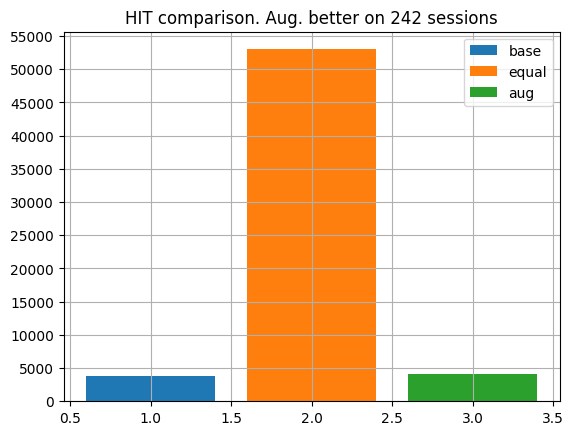

In [36]:
a,b,c=(sum(stats_df.base_hit>stats_df.aug_hit),
sum(stats_df.base_hit==stats_df.aug_hit),
sum(stats_df.base_hit<stats_df.aug_hit))
plt.title(f'HIT comparison. Aug. better on {c-a} sessions')
plt.bar([1,2, 3], height=[a,b,c],
label=['base','equal','aug'],
color=['C0','C1','C2'])
plt.yticks(np.arange(0,max(a,b,c)+5000, 5000))
plt.grid()
plt.legend()
plt.show()

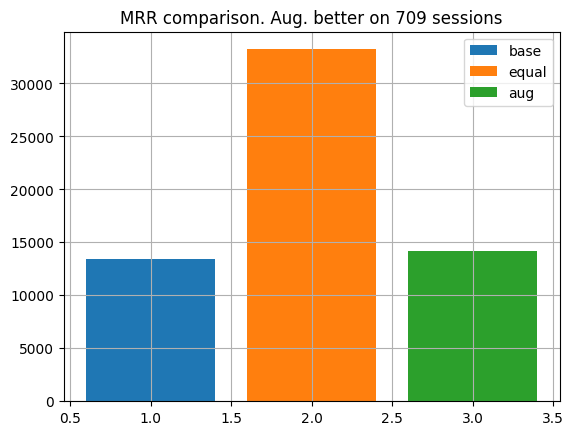

In [37]:
a,b,c=(sum(stats_df.base_mrr>stats_df.aug_mrr),
sum(stats_df.base_mrr==stats_df.aug_mrr),
sum(stats_df.base_mrr<stats_df.aug_mrr))

plt.title(f'MRR comparison. Aug. better on {c-a} sessions')
plt.bar([1,2, 3], height=[a,b,c], 
label=['base','equal','aug'],
color=['C0','C1','C2'])
plt.yticks(np.arange(0,max(a,b,c), 5000))
plt.grid()
plt.legend()
plt.show()

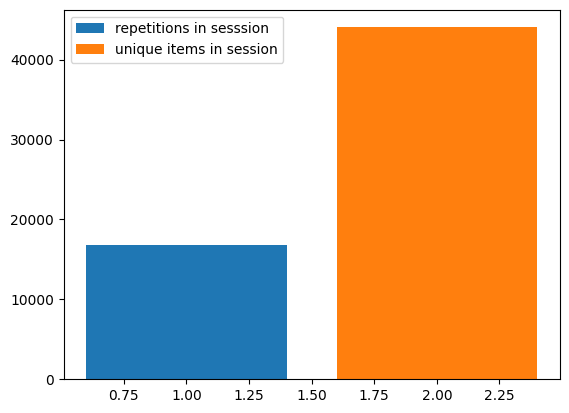

In [29]:
plt.bar([1,2], height=[
    sum(stats_df.repetitions_in_session),
    sum(~stats_df.repetitions_in_session)
], label=['repetitions in sesssion', 'unique items in session'],
color=['C0', 'C1'])
plt.legend()
plt.show()

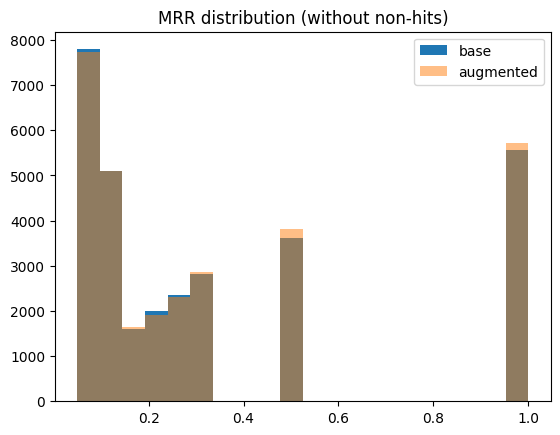

In [40]:
plt.hist(stats_df.base_mrr[stats_df.base_mrr>0], bins=20, label='base')
plt.hist(stats_df.aug_mrr[stats_df.aug_mrr>0], bins=20, label='augmented', alpha=0.5)
plt.legend()
plt.title('MRR distribution (without non-hits)')
plt.show()

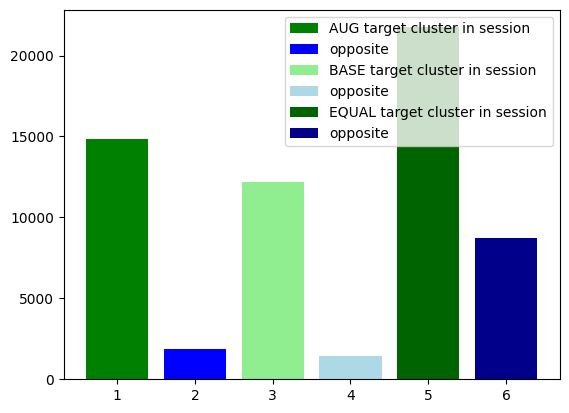

In [206]:
plt.bar([1,2,3,4,5,6], height=[
    sum(aug_df.target_cluster_in_ses),
    sum(~aug_df.target_cluster_in_ses),
    sum(base_df.target_cluster_in_ses),
    sum(~base_df.target_cluster_in_ses),
    sum(equal_df.target_cluster_in_ses),
    sum(~equal_df.target_cluster_in_ses)
], label=['AUG target cluster in session', 'opposite', 
          'BASE target cluster in session', 'opposite', 
          'EQUAL target cluster in session', 'opposite', ],
color=['green', 'blue', 'lightgreen', 'lightblue', 'darkgreen', 'darkblue'])
plt.legend()
plt.show()

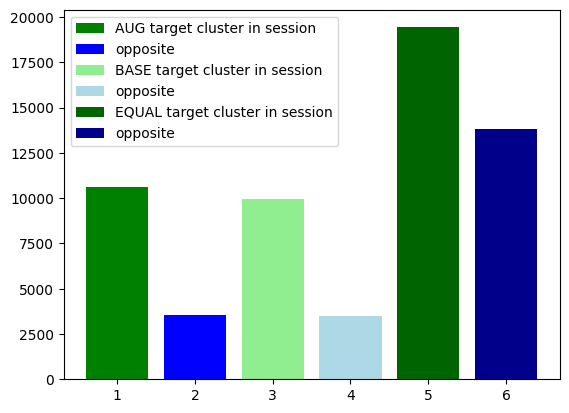

In [41]:
plt.bar([1,2,3,4,5,6], height=[
    sum(aug_df.target_cluster_in_ses),
    sum(~aug_df.target_cluster_in_ses),
    sum(base_df.target_cluster_in_ses),
    sum(~base_df.target_cluster_in_ses),
    sum(equal_df.target_cluster_in_ses),
    sum(~equal_df.target_cluster_in_ses)
], label=['AUG target cluster in session', 'opposite', 
          'BASE target cluster in session', 'opposite', 
          'EQUAL target cluster in session', 'opposite', ],
color=['green', 'blue', 'lightgreen', 'lightblue', 'darkgreen', 'darkblue'])
plt.legend()
plt.show()

#### repetitions, clusters & session len

In [51]:
aug_df=stats_df.loc[
    (stats_df.base_mrr<stats_df.aug_mrr)
]
base_df=stats_df.loc[
    (stats_df.base_mrr>stats_df.aug_mrr)
]

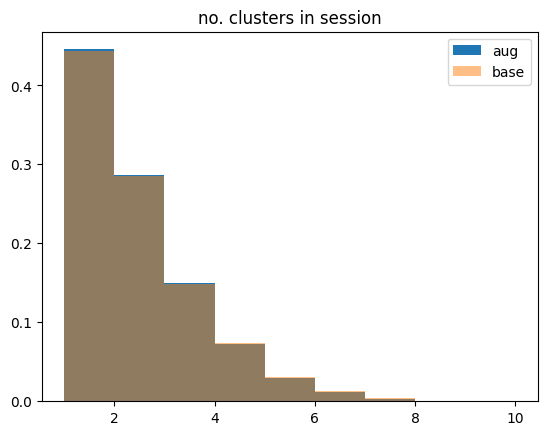

In [42]:

plt.title('no. clusters in session')
plt.hist(aug_df.no_clusters.values, bins=np.arange(stop=aug_df.no_clusters.nunique(), start=1), density=True, label='aug')
plt.hist(base_df.no_clusters.values, bins=np.arange(stop=base_df.no_clusters.nunique(), start=1), alpha=0.5, density=True, label='base')
plt.legend()
plt.show()

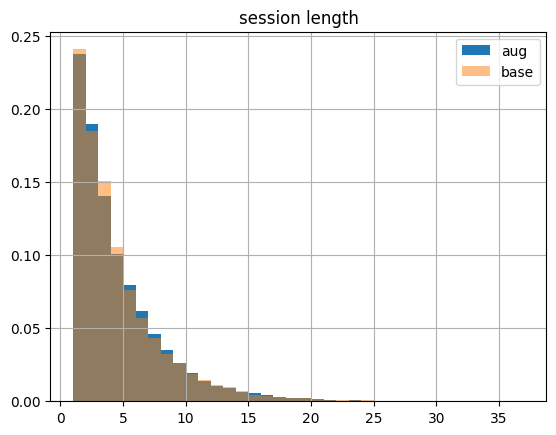

In [43]:
plt.title('session length')
plt.hist(aug_df.session_len.values, bins=np.arange(stop=aug_df.session_len.nunique(), start=1), density=True, label='aug')
plt.hist(base_df.session_len.values, bins=np.arange(stop=base_df.session_len.nunique(), start=1), alpha=0.5, density=True, label='base')
plt.legend()
plt.grid()
plt.show()

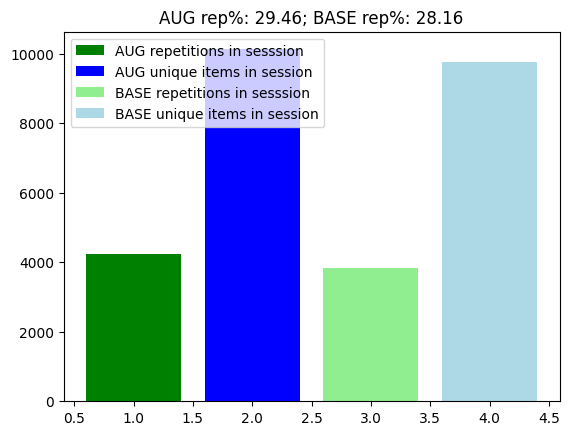

In [80]:
a,b,c,d=(sum(aug_df.repetitions_in_session),
    sum(~aug_df.repetitions_in_session),
    sum(base_df.repetitions_in_session),
    sum(~base_df.repetitions_in_session))

plt.bar([1,2,3,4], height=[
    sum(aug_df.repetitions_in_session),
    sum(~aug_df.repetitions_in_session),
    sum(base_df.repetitions_in_session),
    sum(~base_df.repetitions_in_session)
], label=['AUG repetitions in sesssion', 'AUG unique items in session', 'BASE repetitions in sesssion', 'BASE unique items in session'],
color=['green', 'blue', 'lightgreen', 'lightblue'])
plt.legend()

plt.title(f'AUG rep%: {100*a/(a+b):.2f}; BASE rep%: {100*c/(c+d):.2f}')
plt.show()

#### due to normalization, diff should be only on session with repetition. CHECK it

not really. Adjacency matrix indeed is different only then, but models weights differ all the time

In [26]:
rep_df=stats_df.loc[stats_df.repetitions_in_session]
print('session with repetition #', rep_df.shape[0], ', Base hits:', sum(rep_df.base_hit), ', Aug hits:', sum(rep_df.aug_hit),
      '\n Percentage of different MRR results:', np.round(100*sum(rep_df.base_mrr!=rep_df.aug_mrr)/rep_df.shape[0], 2),'%')

session with repetition # 16813 , Base hits: 9449.0 , Aug hits: 9514.0 
 Percentage of different MRR results: 47.9 %


In [27]:
notrep_df=stats_df.loc[~stats_df.repetitions_in_session]
print('Sessions without repetition! #', notrep_df.shape[0], ', Base hits:', sum(notrep_df.base_hit), ', Aug hits:', sum(notrep_df.aug_hit),
      '\n Percentage of different MRR esults:', np.round(100*sum(notrep_df.base_mrr!=notrep_df.aug_mrr)/notrep_df.shape[0], 2),'%')

Sessions without repetition! # 44045 , Base hits: 21539.0 , Aug hits: 21674.0 
 Percentage of different MRR esults: 45.15 %


In [90]:
print('Percentage gain in sessions with repetitions, regarding better MRR ')
100*((rep_df.aug_mrr>rep_df.base_mrr).sum()-(rep_df.aug_mrr<rep_df.base_mrr).sum())/len(rep_df)

Percentage gain in sessions with repetitions, regarding better MRR 


2.3791114018913935

#### frequency

In [50]:
stats_df=stats_df.merge(items_df[['pricelog2','category','frequency','item_number']].rename(columns={'item_number':'target_number'}), 
             on='target_number',
             how='left')
stats_df['avg_sesssion_freq']=list(map(lambda ses: np.average([items_df.loc[items_df.item_number==x].frequency.item() for x in ses]) ,test_sessions))

In [51]:
aug_df=stats_df.loc[
    (stats_df.base_mrr<stats_df.aug_mrr)
]
base_df=stats_df.loc[
    (stats_df.base_mrr>stats_df.aug_mrr)
]
equal_df=stats_df.loc[
    (stats_df.base_mrr==stats_df.aug_mrr)
]

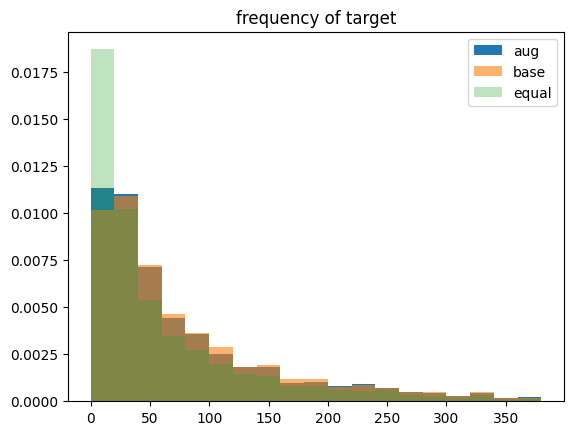

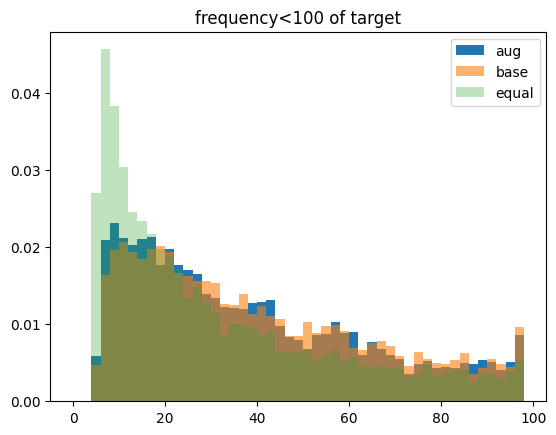

In [52]:

plt.title('frequency of target')
plt.hist(aug_df.frequency.values, bins=np.arange(400, step=20), density=True, label='aug')
plt.hist(base_df.frequency.values, bins=np.arange(400, step=20), alpha=0.6, density=True, label='base')
plt.hist(equal_df.frequency.values, bins=np.arange(400, step=20), alpha=0.3, density=True, label='equal')
plt.legend()
plt.show()


plt.title('frequency<100 of target')
plt.hist(aug_df.frequency.values, bins=np.arange(100, step=2), density=True, label='aug')
plt.hist(base_df.frequency.values, bins=np.arange(100, step=2), alpha=0.6, density=True, label='base')
plt.hist(equal_df.frequency.values, bins=np.arange(100, step=2), alpha=0.3, density=True, label='equal')
plt.legend()
plt.show()

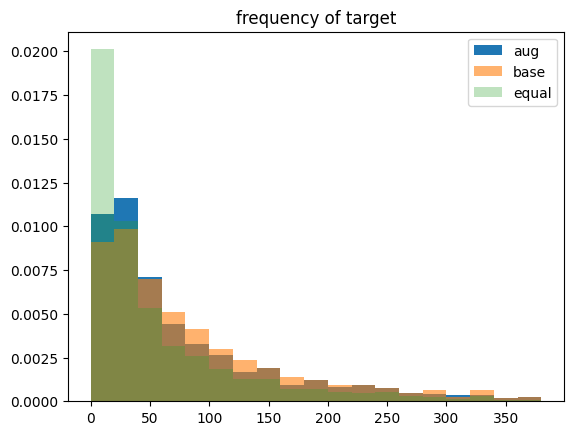

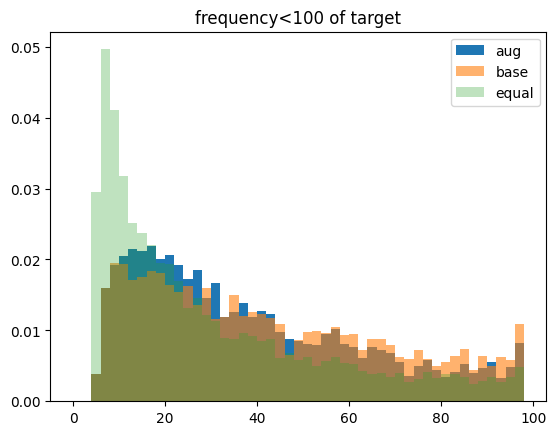

In [70]:

plt.title('frequency of target')
plt.hist(aug_df.frequency.values, bins=np.arange(400, step=20), density=True, label='aug')
plt.hist(base_df.frequency.values, bins=np.arange(400, step=20), alpha=0.6, density=True, label='base')
plt.hist(equal_df.frequency.values, bins=np.arange(400, step=20), alpha=0.3, density=True, label='equal')
plt.legend()
plt.show()


plt.title('frequency<100 of target')
plt.hist(aug_df.frequency.values, bins=np.arange(100, step=2), density=True, label='aug')
plt.hist(base_df.frequency.values, bins=np.arange(100, step=2), alpha=0.6, density=True, label='base')
plt.hist(equal_df.frequency.values, bins=np.arange(100, step=2), alpha=0.3, density=True, label='equal')
plt.legend()
plt.show()

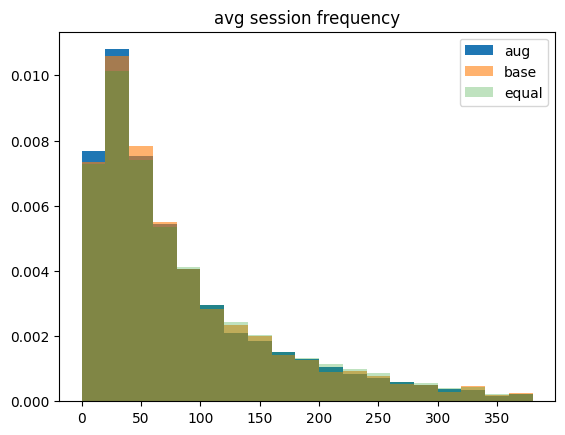

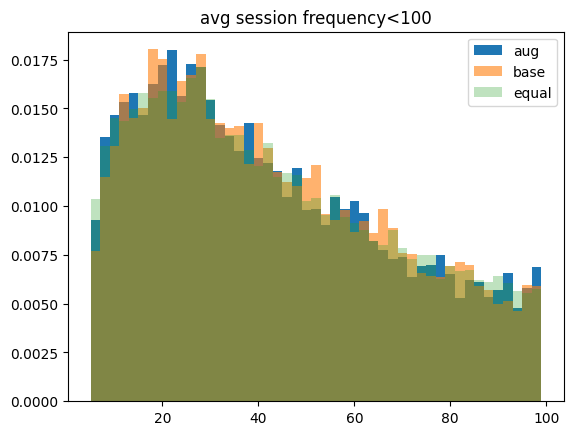

In [57]:

plt.title('avg session frequency')
plt.hist(aug_df.avg_sesssion_freq.values, bins=np.arange(400, step=20), density=True, label='aug')
plt.hist(base_df.avg_sesssion_freq.values, bins=np.arange(400, step=20), alpha=0.6, density=True, label='base')
plt.hist(equal_df.avg_sesssion_freq.values, bins=np.arange(400, step=20), alpha=0.3, density=True, label='equal')
plt.legend()
plt.show()


plt.title('avg session frequency<100')
plt.hist(aug_df.avg_sesssion_freq.values, bins=np.arange(stop=100, start=5, step=2), density=True, label='aug')
plt.hist(base_df.avg_sesssion_freq.values, bins=np.arange(stop=100, start=5, step=2), alpha=0.6, density=True, label='base')
plt.hist(equal_df.avg_sesssion_freq.values, bins=np.arange(stop=100, start=5, step=2), alpha=0.3, density=True, label='equal')
plt.legend()
plt.show()

#### price

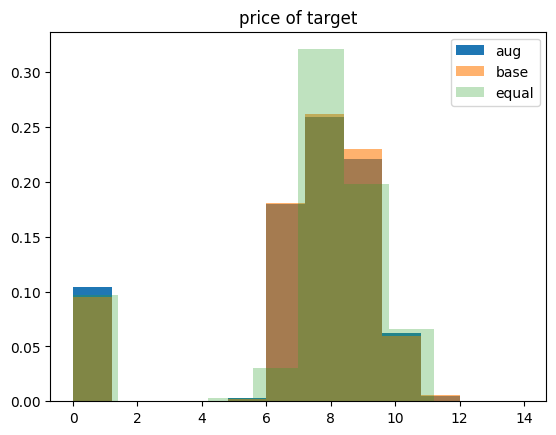

In [58]:
plt.title('price of target')
plt.hist(aug_df.pricelog2.values, bins=10, density=True, label='aug')
plt.hist(base_df.pricelog2.values, bins=10, alpha=0.6, density=True, label='base')
plt.hist(equal_df.pricelog2.values, bins=10, alpha=0.3, density=True, label='equal')
plt.legend()
plt.show()

#### embedding distance

In [33]:
base_emb_center=np.average(base_items_embeddings, axis=0)
aug_emb_center=np.average(aug_items_embeddings, axis=0)

In [34]:
stats_df['base_sesssion_emb']=(list(map(lambda ses: np.average(base_items_embeddings[ses], axis=0) ,test_sessions)))
stats_df['aug_sesssion_emb']=list(map(lambda ses: np.average(aug_items_embeddings[ses], axis=0) ,test_sessions))


In [35]:
aug_df=stats_df.loc[
    (stats_df.base_mrr<stats_df.aug_mrr)
]
base_df=stats_df.loc[
    (stats_df.base_mrr>stats_df.aug_mrr)
]
equal_df=stats_df.loc[
    (stats_df.base_mrr==stats_df.aug_mrr)
]

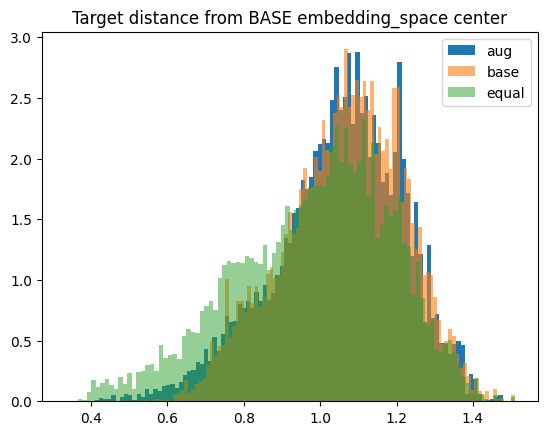

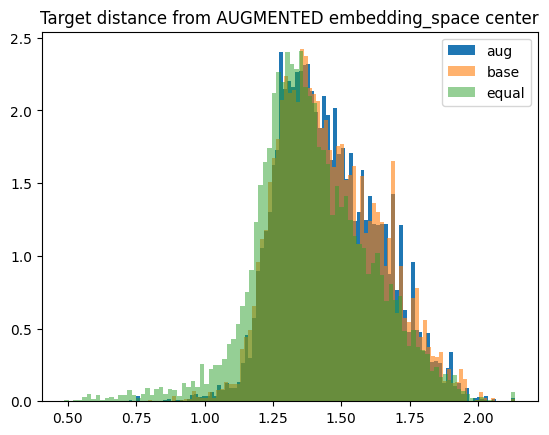

In [36]:

plt.title('Target distance from BASE embedding_space center')
plt.hist(np.linalg.norm(base_items_embeddings[aug_df.target_number.values]-base_emb_center, axis=1), 
         bins=100, density=True, label='aug')

plt.hist(np.linalg.norm(base_items_embeddings[base_df.target_number.values]-base_emb_center, axis=1),  
         bins=100, alpha=0.6, density=True, label='base')
plt.hist(np.linalg.norm(base_items_embeddings[equal_df.target_number.values]-base_emb_center, axis=1), 
         bins=100, alpha=0.5, density=True, label='equal')
plt.legend()
plt.show()



plt.title('Target distance from AUGMENTED embedding_space center')
plt.hist(np.linalg.norm(aug_items_embeddings[aug_df.target_number.values]-aug_emb_center, axis=1), 
         bins=100, density=True, label='aug')

plt.hist(np.linalg.norm(aug_items_embeddings[base_df.target_number.values]-aug_emb_center, axis=1),  
         bins=100, alpha=0.6, density=True, label='base')
plt.hist(np.linalg.norm(aug_items_embeddings[equal_df.target_number.values]-aug_emb_center, axis=1), 
         bins=100, alpha=0.5, density=True, label='equal')
plt.legend()
plt.show()



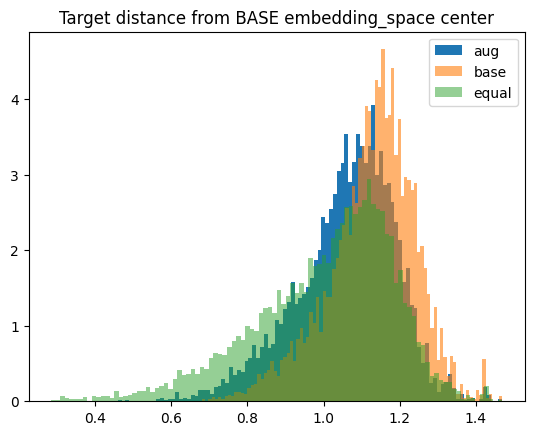

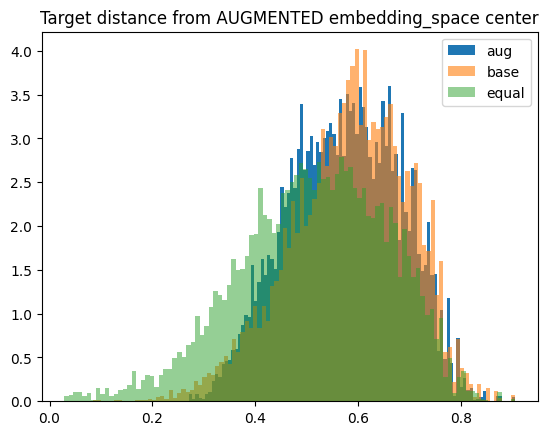

In [120]:
### OLDDDDDDDDDDDDD
plt.title('Target distance from BASE embedding_space center')
plt.hist(np.linalg.norm(base_items_embeddings[aug_df.target_number.values]-base_emb_center, axis=1), 
         bins=100, density=True, label='aug')

plt.hist(np.linalg.norm(base_items_embeddings[base_df.target_number.values]-base_emb_center, axis=1),  
         bins=100, alpha=0.6, density=True, label='base')
plt.hist(np.linalg.norm(base_items_embeddings[equal_df.target_number.values]-base_emb_center, axis=1), 
         bins=100, alpha=0.5, density=True, label='equal')
plt.legend()
plt.show()



plt.title('Target distance from AUGMENTED embedding_space center')
plt.hist(np.linalg.norm(aug_items_embeddings[aug_df.target_number.values]-aug_emb_center, axis=1), 
         bins=100, density=True, label='aug')

plt.hist(np.linalg.norm(aug_items_embeddings[base_df.target_number.values]-aug_emb_center, axis=1),  
         bins=100, alpha=0.6, density=True, label='base')
plt.hist(np.linalg.norm(aug_items_embeddings[equal_df.target_number.values]-aug_emb_center, axis=1), 
         bins=100, alpha=0.5, density=True, label='equal')
plt.legend()
plt.show()



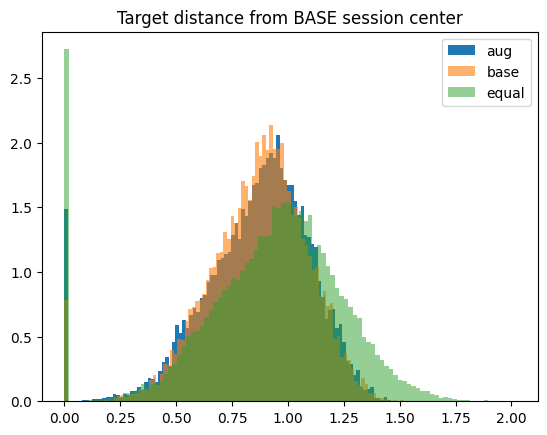

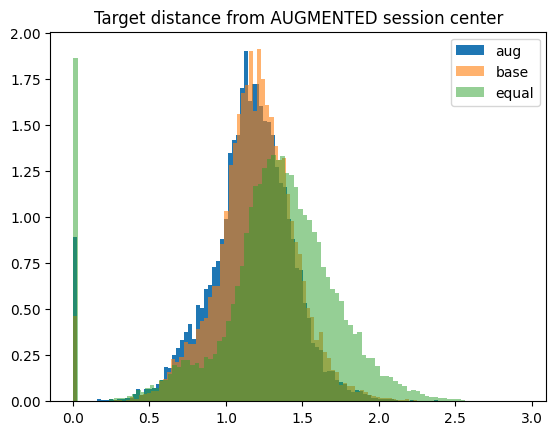

In [37]:

plt.title('Target distance from BASE session center')
plt.hist(np.linalg.norm(base_items_embeddings[aug_df.target_number.values]-np.asarray([x for x in aug_df.base_sesssion_emb.values]), 
                        axis=1), 
         bins=100, density=True, label='aug')

plt.hist(np.linalg.norm(base_items_embeddings[base_df.target_number.values]-np.asarray([x for x in base_df.base_sesssion_emb.values]), axis=1),  
         bins=100, alpha=0.6, density=True, label='base')
plt.hist(np.linalg.norm(base_items_embeddings[equal_df.target_number.values]-np.asarray([x for x in equal_df.base_sesssion_emb.values]), axis=1), 
         bins=100, alpha=0.5, density=True, label='equal')
plt.legend()
plt.show()



plt.title('Target distance from AUGMENTED session center')
plt.hist(np.linalg.norm(aug_items_embeddings[aug_df.target_number.values]-np.asarray([x for x in aug_df.aug_sesssion_emb.values]), axis=1), 
         bins=100, density=True, label='aug')

plt.hist(np.linalg.norm(aug_items_embeddings[base_df.target_number.values]-np.asarray([x for x in base_df.aug_sesssion_emb.values]), axis=1),  
         bins=100, alpha=0.6, density=True, label='base')
plt.hist(np.linalg.norm(aug_items_embeddings[equal_df.target_number.values]-np.asarray([x for x in equal_df.aug_sesssion_emb.values]), axis=1), 
         bins=100, alpha=0.5, density=True, label='equal')
plt.legend()
plt.show()



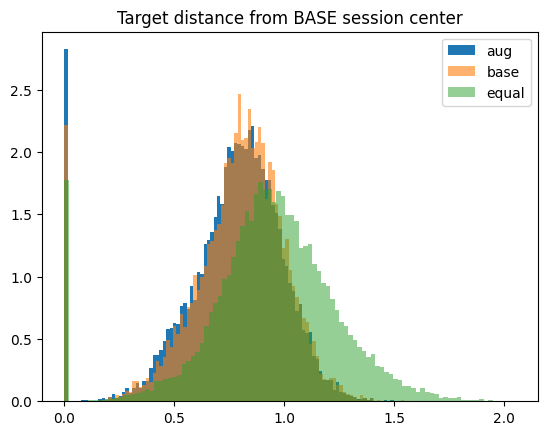

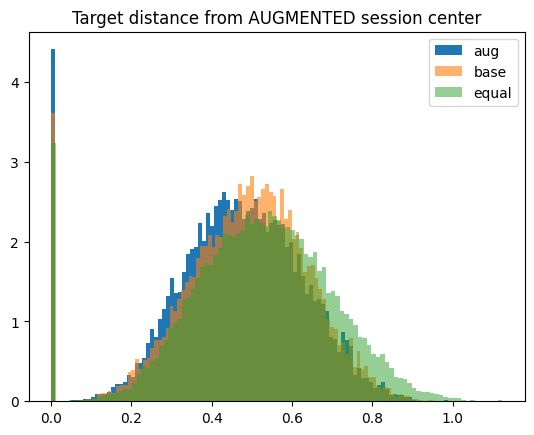

In [172]:
###### OLDDDDDDDDDDDDDDDDDDd
plt.title('Target distance from BASE session center')
plt.hist(np.linalg.norm(base_items_embeddings[aug_df.target_number.values]-np.asarray([x for x in aug_df.base_sesssion_emb.values]), 
                        axis=1), 
         bins=100, density=True, label='aug')

plt.hist(np.linalg.norm(base_items_embeddings[base_df.target_number.values]-np.asarray([x for x in base_df.base_sesssion_emb.values]), axis=1),  
         bins=100, alpha=0.6, density=True, label='base')
plt.hist(np.linalg.norm(base_items_embeddings[equal_df.target_number.values]-np.asarray([x for x in equal_df.base_sesssion_emb.values]), axis=1), 
         bins=100, alpha=0.5, density=True, label='equal')
plt.legend()
plt.show()



plt.title('Target distance from AUGMENTED session center')
plt.hist(np.linalg.norm(aug_items_embeddings[aug_df.target_number.values]-np.asarray([x for x in aug_df.aug_sesssion_emb.values]), axis=1), 
         bins=100, density=True, label='aug')

plt.hist(np.linalg.norm(aug_items_embeddings[base_df.target_number.values]-np.asarray([x for x in base_df.aug_sesssion_emb.values]), axis=1),  
         bins=100, alpha=0.6, density=True, label='base')
plt.hist(np.linalg.norm(aug_items_embeddings[equal_df.target_number.values]-np.asarray([x for x in equal_df.aug_sesssion_emb.values]), axis=1), 
         bins=100, alpha=0.5, density=True, label='equal')
plt.legend()
plt.show()



#### same but on clusters

In [66]:
with open(f"../datasets/{opt.dataset}/cluster_centers_16_{opt.hiddenSize}_{base_run_id.split('-')[-1]}.txt", 
            'rb') as f:
      cluster_centers=pickle.load(f)

In [69]:
stats_df['cluster_sesssion_emb']=(list(map(lambda ses: np.average(cluster_centers[item_labels[ses]], axis=0) ,test_sessions)))
aug_df=stats_df.loc[
    (stats_df.base_mrr<stats_df.aug_mrr)
]
base_df=stats_df.loc[
    (stats_df.base_mrr>stats_df.aug_mrr)
]
equal_df=stats_df.loc[
    (stats_df.base_mrr==stats_df.aug_mrr)
]

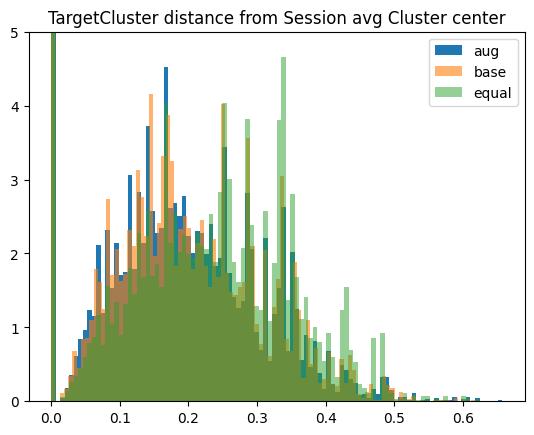

In [72]:

plt.title('TargetCluster distance from Session avg Cluster center')
plt.hist(np.linalg.norm(cluster_centers[item_labels[aug_df.target_number.values]]-np.asarray([x for x in aug_df.cluster_sesssion_emb.values]), 
                        axis=1), 
         bins=100, density=True, label='aug')

plt.hist(np.linalg.norm(cluster_centers[item_labels[base_df.target_number.values]]-np.asarray([x for x in base_df.cluster_sesssion_emb.values]), axis=1),  
         bins=100, alpha=0.6, density=True, label='base')
plt.hist(np.linalg.norm(cluster_centers[item_labels[equal_df.target_number.values]]-np.asarray([x for x in equal_df.cluster_sesssion_emb.values]), axis=1), 
         bins=100, alpha=0.5, density=True, label='equal')
plt.legend()
plt.ylim(0, 5)
plt.show()

##### plot & compare embeddings

In [76]:
tsne=TSNE(2, init='random', early_exaggeration=32)
tsne_items_embeddings=tsne.fit_transform(aug_items_embeddings)

fig = go.Figure()

for label in np.unique(item_labels):
    label_embedding=tsne_items_embeddings[item_labels==label]
    fig.add_trace(go.Scatter(x=label_embedding[:,0], y=label_embedding[:,1], name=str(label), mode='markers'))

fig.update_layout(title='TSNE reduced items embeddings from model with augmented adjacency matrix',
                  margin=dict(l=40, r=40, t=40, b=40),
                  width=1000, height=800)
fig.write_html(f'./images/items_AUGMATRIX_tsne{tsne.init}_{opt.dataset}_{opt.hiddenSize}_{base_run_id.split("-")[-1]}_{aug_run_id.split("-")[-1]}.html')
del fig
#fig.show()

In [77]:
tsne=TSNE(2, init='random', early_exaggeration=32)
tsne_items_embeddings=tsne.fit_transform(base_items_embeddings)


fig = go.Figure()

for label in np.unique(item_labels):
    label_embedding=tsne_items_embeddings[item_labels==label]
    fig.add_trace(go.Scatter(x=label_embedding[:,0], y=label_embedding[:,1], name=str(label), mode='markers'))

fig.update_layout(title='TSNE reduced items embeddings from model with augmented adjacency matrix',
                  margin=dict(l=40, r=40, t=40, b=40),
                  width=1000, height=800)
fig.write_html(f'./images/items_BASE_tsne{tsne.init}_{opt.dataset}_{opt.hiddenSize}_{base_run_id.split("-")[-1]}_{aug_run_id.split("-")[-1]}.html')
del fig
#fig.show()

#### Categories

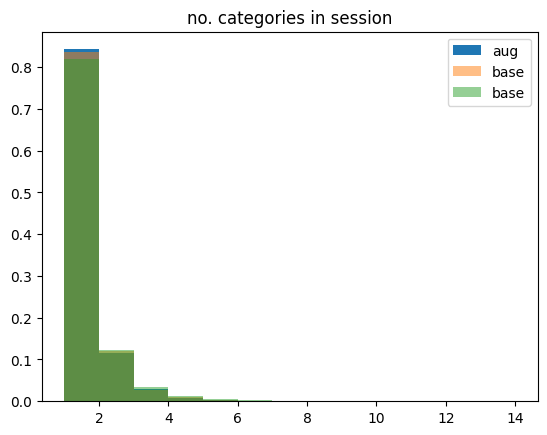

In [78]:

plt.title('no. categories in session')
plt.hist(aug_df.no_categories.values, bins=np.arange(stop=stats_df.no_categories.nunique(), start=1), density=True, label='aug')
plt.hist(base_df.no_categories.values, bins=np.arange(stop=stats_df.no_categories.nunique(), start=1), alpha=0.5, density=True, label='base')
plt.hist(equal_df.no_categories.values, bins=np.arange(stop=stats_df.no_categories.nunique(), start=1), alpha=0.5, density=True, label='base')
plt.legend()
plt.show()

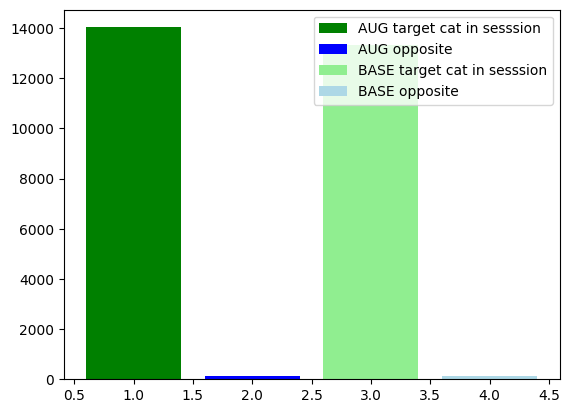

In [81]:
plt.bar([1,2,3,4], height=[
    sum(aug_df.target_category_in_ses),
    sum(~aug_df.target_category_in_ses),
    sum(base_df.target_category_in_ses),
    sum(~base_df.target_category_in_ses)
], label=['AUG target cat in sesssion', 'AUG opposite', 'BASE target cat in sesssion', 'BASE opposite'],
color=['green', 'blue', 'lightgreen', 'lightblue'])
plt.legend()
plt.show()

## train tsne

In [23]:
tsne=TSNE(2, init='random', early_exaggeration=32, verbose=1)
base_tsne_items_embeddings=tsne.fit_transform(base_items_embeddings)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 43098 samples in 0.003s...
[t-SNE] Computed neighbors for 43098 samples in 2.110s...
[t-SNE] Computed conditional probabilities for sample 1000 / 43098
[t-SNE] Computed conditional probabilities for sample 2000 / 43098
[t-SNE] Computed conditional probabilities for sample 3000 / 43098
[t-SNE] Computed conditional probabilities for sample 4000 / 43098
[t-SNE] Computed conditional probabilities for sample 5000 / 43098
[t-SNE] Computed conditional probabilities for sample 6000 / 43098
[t-SNE] Computed conditional probabilities for sample 7000 / 43098
[t-SNE] Computed conditional probabilities for sample 8000 / 43098
[t-SNE] Computed conditional probabilities for sample 9000 / 43098
[t-SNE] Computed conditional probabilities for sample 10000 / 43098
[t-SNE] Computed conditional probabilities for sample 11000 / 43098
[t-SNE] Computed conditional probabilities for sample 12000 / 43098
[t-SNE] Computed conditional probabilities for sam

In [ ]:
tsne=TSNE(2, init='random', early_exaggeration=32, verbose=1)
aug_tsne_items_embeddings=tsne.fit_transform(aug_items_embeddings)

## visualize single session

In [ ]:
'base', np.linalg.norm(base_items_embeddings.max(axis=0)-base_items_embeddings.min(axis=0)), 'aug', np.linalg.norm(aug_items_embeddings.max(axis=0)-aug_items_embeddings.min(axis=0))

('base', 7.861786, 'aug', 10.256786)

In [24]:
import plotly.express as px
import plotly.graph_objects as go

colors=px.colors.qualitative.Plotly

In [88]:
aug_opt.augment_noise_p=0.5
aug_opt.augment_p=1
aug_dataset=get_dataset(aug_opt, test_data, shuffle=False)

{'dataset': 'diginetica', 'batchSize': 100, 'hiddenSize': 100, 'epoch': 30, 'lr': 0.001, 'lr_dc': 0.1, 'lr_dc_step': 2, 'l2': 1e-05, 'step': 2, 'patience': 5, 'nonhybrid': False, 'validation': True, 'valid_portion': 0.1, 'pretrained_embedings': False, 'unfreeze_epoch': 0, 'gmm': True, 'augment_matrix': False, 'augment_clusters': False, 'augment_old_run_id': None, 'augment_clip': 0, 'augment_normalize': False, 'augment_raw': False, 'weight_init': 'normal', 'augment_categories': False, 'augment_nogmm': 16, 'augment_p': 1.0, 'augment_mean': 0.01, 'augment_std': 0.0, 'augment_gmm_init': 'k-means++', 'augment_prenormalize_distances': False, 'augment_noise_p': 1, 'augment_alg': 'gmm', 'gmm_covariance_type': 'full', 'gmm_tol': 0.001}
data masking start


100%|██████████| 64/64 [00:00<00:00, 419.30it/s]

done masking


In [27]:
base_hit5=stats_df.base_mrr>=0.2
aug_hit5=stats_df.aug_mrr>=0.2
100*np.average(base_hit5), 100*np.average(aug_hit5)

(26.989056492162085, 27.41956686056065)

In [77]:
idx=np.random.choice(rep_df.loc[(rep_df.aug_mrr>rep_df.base_mrr)
           &(rep_df.no_categories>1)].index)

In [28]:
#idx=12906
idx=27278
#idx=34098
seqence=test_sessions[idx]
target=test_targets[idx]
r=rep_df.loc[idx]
idx, r.base_mrr, r.aug_mrr, seqence, target

(27278,
 0.20000000298023224,
 1.0,
 [1708, 9040, 1708, 16172, 1708, 28275, 9040, 4960, 19859, 4951],
 19859)

In [33]:
test_dataset[[idx]][0]

array([[1, 4, 1, 5, 1, 7, 4, 3, 6, 2, 0]])

In [80]:
a=(np.round(aug_dataset[[idx,idx]][1], decimals=3)[0])
s=''
for i in a:
    s+='&'+'&'.join(['\\textbf{'+str(j)+'}' if j>0.2 else (str(j) if j!=int(j) else str(int(j))) for j in i[len(i)//2:] ])+'\\\\ \\hline'+'\n'
print(s)

&0&0&0&0.015&0&0.011&0.016&-0.008&0.027&0&0.014&0.026&0\\ \hline
&0.018&-0.003&0.012&0&0&0&\textbf{1.031}&0.027&0.019&0&0&0&0.016\\ \hline
&0&0.016&0&0&0.001&-0.012&0&0.012&0&0&\textbf{1.019}&0&0.033\\ \hline
&0&0.024&0&0&0&\textbf{0.499}&0&-0.001&0&0&0.007&0.002&\textbf{0.506}\\ \hline
&0.007&0&0.016&0.021&0.003&-0.003&0&0&0&0&0&0.005&0\\ \hline
&0.001&0.003&0&0&0&0.007&0.023&\textbf{1.0}&0.012&0&0.01&-0.006&0\\ \hline
&0.023&0&0&0&0.011&0&0.003&0.003&0&0&0&\textbf{1.004}&0\\ \hline
&0&0.003&0&0.003&0.014&0&0.011&0.002&0.014&\textbf{1.003}&0.011&0.022&0\\ \hline
&0&-0.001&0&\textbf{1.0}&0&0.011&0&0&0&-0.011&0.025&0&0\\ \hline
&0&0&0.013&0&0&0&-0.002&0.007&\textbf{0.995}&-0.008&0.019&0&0\\ \hline
&0&\textbf{1.0}&0&0.018&0&0.016&0&0.034&0.026&0.001&0&0&0\\ \hline
&0.018&0.008&0.023&\textbf{1.0}&0.002&0&0&0&0.016&0.012&0&0.006&0.031\\ \hline
&-0.014&0&0&0&\textbf{1.0}&0.02&0.017&0.031&0.025&0.005&0.009&0.01&0\\ \hline



In [111]:
a=(np.round(test_dataset[[idx, idx]][1], decimals=3)[0])
s=''
for k, i in enumerate(a):
    s+=f'{k}&'+'&'.join(['\\textbf{'+str(j)+'}' if j>0.2 else (str(j) if j!=int(j) else str(int(j))) for j in i[len(i)//2:] ])+'\\\\ \\hline'+'\n'
print(s)

0&0&0&0&0&0&0&0&0\\ \hline
1&0&0&0&0&\textbf{0.333}&\textbf{0.333}&0&\textbf{0.333}\\ \hline
2&0&0&0&0&0&0&0&0\\ \hline
3&0&0&0&0&0&0&\textbf{1.0}&0\\ \hline
4&0&\textbf{0.5}&0&\textbf{0.5}&0&0&0&0\\ \hline
5&0&\textbf{1.0}&0&0&0&0&0&0\\ \hline
6&0&0&\textbf{1.0}&0&0&0&0&0\\ \hline
7&0&0&0&0&\textbf{1.0}&0&0&0\\ \hline



In [107]:
l=[]
for i in range(1, r.session_len):
    print(f'{i}->{i+1}',
          'base ',
          np.linalg.norm(base_items_embeddings[seqence[i]]-base_items_embeddings[seqence[i-1]]),
          'aug ',
          np.linalg.norm(aug_items_embeddings[seqence[i]]-aug_items_embeddings[seqence[i-1]]),
          )
print('last->target',
        'base ',
      np.linalg.norm(base_items_embeddings[seqence[-1]]-base_items_embeddings[target]),
        'aug ',
      np.linalg.norm(aug_items_embeddings[seqence[-1]]-aug_items_embeddings[target]),
      )

1->2 base  1.0781479 aug  1.1431069
2->3 base  1.0781479 aug  1.1431069
3->4 base  1.2256006 aug  1.4402343
4->5 base  1.2256006 aug  1.4402343
5->6 base  1.1176201 aug  1.4757541
6->7 base  1.2545925 aug  1.3634489
7->8 base  1.1886706 aug  1.4369689
8->9 base  1.0056984 aug  1.6463287
9->10 base  1.0773515 aug  1.5296794
last->target base  1.0773515 aug  1.5296794


In [108]:
seqence, target

([1708, 9040, 1708, 16172, 1708, 28275, 9040, 4960, 19859, 4951], 19859)

In [91]:
items_df.loc[items_df.item_number.isin(seqence+[target])]

,item_id,pricelog2,product.name.tokens,category,item_number,frequency,item_cluster
3054,8144,9,"4875,3741,28012,4531,4531",88,1708,74,0
13576,3024,9,"5729,5729,5730,5730,25804",88,16172,120,0
19428,11269,9,"5729,5729,5730,5730,384623",88,4951,138,0
26747,13026,9,"494061,4531,4531,161",88,19859,24,0
26992,135847,9,"6141,236622,28012,4531,4531",88,4960,28,0
27123,5563,9,"495923,4531,4531",88,28275,31,0
29518,35999,9,"505689,538,538",88,9040,75,0


In [35]:
fig = go.Figure()

for i, item in enumerate(seqence):#[np.unique(item_labels, return_counts=True)[1]>len(item_labels)/ngmm]:
    sequence_embedding=base_tsne_items_embeddings[item] 
    fig.add_trace(go.Scatter(x=[sequence_embedding[0]], y=[sequence_embedding[1]], 
                             name=f'item_{i}', mode='markers', 
                             marker=dict(size=20,
                                       #  color=colors[item_labels[item]],
                                        line=dict(width=2,
                                        color='DarkSlateGrey'))))
    
fig.add_trace(go.Scatter(x=[base_tsne_items_embeddings[target][0]], y=[base_tsne_items_embeddings[target][1]], 
                             name=f'target', mode='markers', 
                            marker=dict(size=30,
                                      #color=colors[item_labels[target]],
                                        line=dict(width=2,
                                        color='DarkSlateGrey'))))

sequence_embedding=base_tsne_items_embeddings[seqence]
fig.add_trace(go.Scatter(x=sequence_embedding[:, 0], y=sequence_embedding[:, 1], 
                             name='session', mode='markers+lines', 
                             marker=dict(symbol="arrow",
                                        size=15,
                                        angleref="previous",
                                        color='Black')
                                        ))

fig.add_trace(go.Scatter(x=[sequence_embedding[-1, 0], base_tsne_items_embeddings[target][0]],
                          y=[sequence_embedding[-1, 1], base_tsne_items_embeddings[target][1]], 
                             name='prediciton', mode='markers+lines', 
                             marker=dict(symbol="arrow",
                                        size=15,
                                        angleref="previous",
                                        color='Red')
                                        ))
    
fig.update_layout(title='',
                  margin=dict(l=40, r=40, t=40, b=40),
                  width=1000, height=800)
fig.write_html(f'./images/sequence_BASE_tsne_{tsne.init}_{opt.dataset}_{aug_opt.augment_alg}_{base_run_id.split("-")[-1]}.html')
del fig

In [36]:
fig = go.Figure()

for i, item in enumerate(seqence):#[np.unique(item_labels, return_counts=True)[1]>len(item_labels)/ngmm]:
    sequence_embedding=aug_tsne_items_embeddings[item] 
    fig.add_trace(go.Scatter(x=[sequence_embedding[0]], y=[sequence_embedding[1]], 
                             name=f'item_{i}', mode='markers', 
                             marker=dict(size=20,
                                       #  color=colors[item_labels[item]],
                                        line=dict(width=2,
                                        color='DarkSlateGrey'))))
    
fig.add_trace(go.Scatter(x=[aug_tsne_items_embeddings[target][0]], y=[aug_tsne_items_embeddings[target][1]], 
                             name=f'target', mode='markers', 
                            marker=dict(size=30,
                                      #color=colors[item_labels[target]],
                                        line=dict(width=2,
                                        color='DarkSlateGrey'))))

sequence_embedding=aug_tsne_items_embeddings[seqence]
fig.add_trace(go.Scatter(x=sequence_embedding[:, 0], y=sequence_embedding[:, 1], 
                             name='session', mode='markers+lines', 
                             marker=dict(symbol="arrow",
                                        size=15,
                                        angleref="previous",
                                        color='Black')
                                        ))

fig.add_trace(go.Scatter(x=[sequence_embedding[-1, 0], aug_tsne_items_embeddings[target][0]],
                          y=[sequence_embedding[-1, 1], aug_tsne_items_embeddings[target][1]], 
                             name='prediciton', mode='markers+lines', 
                             marker=dict(symbol="arrow",
                                        size=15,
                                        angleref="previous",
                                        color='Red')
                                        ))
    
fig.update_layout(title='',
                  margin=dict(l=40, r=40, t=40, b=40),
                  width=1000, height=800)
fig.write_html(f'./images/sequence_AUG_tsne_{tsne.init}_{opt.dataset}_{aug_opt.augment_alg}_{aug_run_id.split("-")[-1]}.html')
del fig

NameError: name 'aug_tsne_items_embeddings' is not defined

In [37]:
r

base_mrr                     0.2
base_hit                     1.0
aug_mrr                      1.0
aug_hit                      1.0
session_id                133163
target_number              19859
session_len                   10
repetitions_in_session      True
target_category               88
categories                  {88}
target_category_in_ses      True
no_categories                  1
Name: 27278, dtype: object

In [38]:
sess_df.loc[sess_df.session_id==133163]

,queryId,session_id,userId,timeframe,duration,eventdate,searchstring.tokens,category,items
5550,157797,133163,NaN,0,1061,2016-05-29,NaN,88,"50,30267,30327,30507,20952,543,30541,21053,306..."


### compare recommendations between all approaches

In [64]:
base_run_id='jxgwsuta' # diginetica
#base_run_id='run-20240422_103727-ex2zwqx6' # yoochoose1/4
base_model,opt=load_model(base_run_id)

i2i_run_id='8llxhkxm'
i2i_model,i2i_opt=load_model(i2i_run_id) # diginetica

cat_run_id='op22qkq4'
cat_model,cat_opt=load_model(cat_run_id) # diginetica

gmm_run_id='7jkmaij6'
gmm_model,gmm_opt=load_model(gmm_run_id) # diginetica

kmeans_run_id='6i71w436'
kmeans_model,kmeans_opt=load_model(kmeans_run_id) # diginetica


{'dataset': 'diginetica', 'batchSize': 100, 'hiddenSize': 100, 'epoch': 30, 'lr': 0.001, 'lr_dc': 0.1, 'lr_dc_step': 2, 'lr_scheduler': 'step', 'lr_milestones': ([2, 5, 8],), 'l2': 1e-05, 'step': 2, 'patience': 5, 'nonhybrid': False, 'validation': True, 'valid_portion': 0.1, 'pretrained_embedings': False, 'unfreeze_epoch': 0, 'gmm': True, 'augment_matrix': False, 'augment_clusters': False, 'augment_old_run_id': None, 'augment_clip': 0, 'augment_normalize': False, 'augment_raw': False, 'weight_init': 'normal', 'augment_categories': False, 'augment_nogmm': 16, 'augment_p': 1.0, 'augment_mean': 0.01, 'augment_std': 0.0, 'augment_gmm_init': 'k-means++', 'augment_prenormalize_distances': False, 'augment_noise_p': 1, 'augment_alg': 'gmm', 'gmm_covariance_type': 'full', 'gmm_tol': 0.001}
{'dataset': 'diginetica', 'batchSize': 100, 'hiddenSize': 100, 'epoch': 30, 'lr': 0.001, 'lr_dc': 0.1, 'lr_dc_step': 2, 'lr_scheduler': 'step', 'lr_milestones': ([2, 5, 8],), 'l2': 1e-06, 'step': 2, 'patience

In [66]:
base_items_embeddings=get_items_embedding(base_model, torch.arange(items_df.item_number.nunique()+1, device=base_model.device)).cpu().detach().numpy()
i2i_items_embeddings=get_items_embedding(i2i_model, torch.arange(items_df.item_number.nunique()+1, device=base_model.device)).cpu().detach().numpy()
cat_items_embeddings=get_items_embedding(cat_model, torch.arange(items_df.item_number.nunique()+1, device=base_model.device)).cpu().detach().numpy()
gmm_items_embeddings=get_items_embedding(gmm_model, torch.arange(items_df.item_number.nunique()+1, device=base_model.device)).cpu().detach().numpy()
kmeans_items_embeddings=get_items_embedding(kmeans_model, torch.arange(items_df.item_number.nunique()+1, device=base_model.device)).cpu().detach().numpy()


In [44]:
batch=[torch.tensor(a) for a in test_dataset[[idx,idx]]]

In [71]:
base_model.to('cpu')
i2i_model.to('cpu')
cat_model.to('cpu')
gmm_model.to('cpu')
kmeans_model.to('cpu')

SRGNN_model(
  (model): SessionGraph(
    (embedding): Embedding(43098, 100)
    (gnn): GNN(
      (linear_edge_in): Linear(in_features=100, out_features=100, bias=True)
      (linear_edge_out): Linear(in_features=100, out_features=100, bias=True)
      (linear_edge_f): Linear(in_features=100, out_features=100, bias=True)
    )
    (linear_one): Linear(in_features=100, out_features=100, bias=True)
    (linear_two): Linear(in_features=100, out_features=100, bias=True)
    (linear_three): Linear(in_features=100, out_features=1, bias=False)
    (linear_transform): Linear(in_features=200, out_features=100, bias=True)
    (loss_function): CrossEntropyLoss()
  )
)

In [72]:
base_preds=base_model.predict_step(batch)[0][0].numpy()+1
i2i_preds=i2i_model.predict_step(batch)[0][0].numpy()+1
cat_preds=cat_model.predict_step(batch)[0][0].numpy()+1
gmm_preds=gmm_model.predict_step(batch)[0][0].numpy()+1
kmeans_preds=kmeans_model.predict_step(batch)[0][0].numpy()+1


In [73]:
base_preds,i2i_preds,cat_preds, gmm_preds, kmeans_preds

(array([ 4951,  9040,   161, 14421, 19859, 38991,  1708, 17892,  3831,
         6345, 16114, 16172,  4324,  4755,  4960,  2566,  3820, 20901,
        15865,  5956]),
 array([19859,  4951,  9040, 38991,   161,  1708, 20901, 14421, 17892,
        16114,  3831,  9041,  5228,  5908,  6786,  2566,  6345,  9039,
         5910,  4950]),
 array([ 1708, 19859,  4951,  9040,   161,  3831, 14421,  4324,  4755,
         9037, 17892, 38991,  6345,  4960,  9744,  5228, 16172, 34470,
         9038, 22001]),
 array([ 9040, 14421,  4951,  1708,   161,  3831, 38991, 19859, 17892,
         2566, 16114,  4755,  6346, 23796,  4960,  5908, 15865,  4324,
         9041, 14087]),
 array([ 1708, 19859,  4951,  9040, 14421,  4755, 38991,  4960,   161,
         5956, 16114,  9038, 28275, 17892,  3820,  6346, 26725, 34470,
         9744,  3831]))

In [75]:
np.linspace(5, 20, 10)

array([ 5.        ,  6.66666667,  8.33333333, 10.        , 11.66666667,
       13.33333333, 15.        , 16.66666667, 18.33333333, 20.        ])

In [79]:
fig = go.Figure()


fig.add_trace(go.Scatter(x=[base_tsne_items_embeddings[target][0]], y=[base_tsne_items_embeddings[target][1]], 
                             name=f'target', mode='markers', 
                            marker=dict(size=30,
                                      #color=colors[item_labels[target]],
                                        line=dict(width=2,
                                        color='DarkSlateGrey'))))

k=10
for preds, name in zip([base_preds, i2i_preds, cat_preds, gmm_preds, kmeans_preds], ['base','i2i','categories','GMM','KMeans']):
  embedding=base_tsne_items_embeddings[preds[:k]] 
  fig.add_trace(go.Scatter(x=embedding[:,0], y=embedding[:,1], 
                              name=name, mode='markers', 
                              marker=dict(size=np.linspace(20,10,k),
                                          opacity=0.5,
                                        #  color=colors[item_labels[item]],
                                          line=dict(width=2,
                                          color='DarkSlateGrey'))))
  



    
fig.update_layout(title='',
                  margin=dict(l=40, r=40, t=40, b=40),
                  width=1000, height=800)
fig.write_html(f'./images/recommendations_tsne_{tsne.init}_{opt.dataset}_{aug_opt.augment_alg}_{aug_run_id.split("-")[-1]}.html')
del fig

#### compare their distance to target

In [81]:
target_emb=base_items_embeddings[target]

In [92]:
target

19859

In [100]:
gmm_preds

array([ 9040, 14421,  4951,  1708,   161,  3831, 38991, 19859, 17892,
        2566, 16114,  4755,  6346, 23796,  4960,  5908, 15865,  4324,
        9041, 14087])

In [106]:
dist_dict={}
k=20
for preds, name in zip([base_preds, i2i_preds, cat_preds, gmm_preds, kmeans_preds], ['base','i2i','categories','GMM','KMeans']):

    dist_dict[name]=[np.linalg.norm(target_emb - base_items_embeddings[x]) for x in preds[:k] if x!=target]

In [107]:
for k,v in dist_dict.items():
    print(f'{k: <11} & ',  ' & '.join([str(x) for x in np.round(np.cumsum(v), decimals=3)]), '\\\\ \\hline')

base        &  1.077 & 2.137 & 3.425 & 4.664 & 5.643 & 6.527 & 7.77 & 9.037 & 10.245 & 11.217 & 12.468 & 13.623 & 14.818 & 15.823 & 17.128 & 18.166 & 19.338 & 20.292 & 21.613 \\ \hline
i2i         &  1.077 & 2.137 & 3.115 & 4.404 & 5.288 & 6.46 & 7.698 & 8.942 & 9.913 & 11.181 & 12.184 & 13.271 & 14.536 & 15.635 & 16.94 & 18.148 & 19.007 & 20.015 & 21.036 \\ \hline
categories  &  0.884 & 1.961 & 3.021 & 4.309 & 5.576 & 6.815 & 7.971 & 9.165 & 10.135 & 11.378 & 12.357 & 13.565 & 14.571 & 15.719 & 16.806 & 18.057 & 19.037 & 20.114 & 21.23 \\ \hline
GMM         &  1.059 & 2.298 & 3.375 & 4.259 & 5.548 & 6.815 & 7.794 & 9.037 & 10.341 & 11.313 & 12.507 & 13.665 & 14.522 & 15.528 & 16.792 & 17.747 & 18.902 & 19.905 & 21.009 \\ \hline
KMeans      &  0.884 & 1.961 & 3.021 & 4.259 & 5.454 & 6.432 & 7.438 & 8.727 & 10.047 & 11.019 & 12.096 & 13.232 & 14.475 & 15.514 & 16.672 & 17.873 & 18.852 & 20.0 & 21.267 \\ \hline
